In [1]:
!pip install timm

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/pkg.7/python3/3.8.6/install/bin/python3.8 -m pip install --upgrade pip' command.


In [1]:
import sys
import warnings

import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
import numpy as np
import pandas as pd
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None, augment=False):
        self.images = images
        self.labels = labels
        self.transform = transform

        self.augment = augment

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = np.array(self.images[idx])

        img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.labels[idx]).type(torch.long)
        sample = (img, label)

        return sample
    
def load_data(path='datasets/fer2013/fer2013.csv'):
    fer2013 = pd.read_csv(path)
    emotion_mapping = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

    return fer2013, emotion_mapping


def prepare_data(data):
    """ Prepare data for modeling
        input: data frame with labels und pixel data
        output: image and label array """

    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

def get_dataloaders(path='datasets/fer2013/fer2013.csv', bs=64, augment=True):
    """ Prepare train, val, & test dataloaders
        Augment training data using:
            - cropping
            - shifting (vertical/horizental)
            - horizental flipping
            - rotation

        input: path to fer2013 csv file
        output: (Dataloader, Dataloader, Dataloader) """

    fer2013, emotion_mapping = load_data(path)

    xtrain, ytrain = prepare_data(fer2013[fer2013['Usage'] == 'Training'])
    xval, yval = prepare_data(fer2013[fer2013['Usage'] == 'PrivateTest'])
    xtest, ytest = prepare_data(fer2013[fer2013['Usage'] == 'PublicTest'])

    mu, st = 0, 255

    test_transform = transforms.Compose([
        # transforms.Scale(52),
        transforms.TenCrop(40),
        transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
        transforms.Lambda(lambda tensors: torch.stack([transforms.Normalize(mean=(mu,), std=(st,))(t) for t in tensors])),
    ])

    if augment:
        train_transform = transforms.Compose([
            transforms.RandomResizedCrop(48, scale=(0.8, 1.2)),
            transforms.RandomApply([transforms.RandomAffine(0, translate=(0.2, 0.2))], p=0.5),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([transforms.RandomRotation(10)], p=0.5),

            transforms.TenCrop(40),
            transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
            transforms.Lambda(lambda tensors: torch.stack([transforms.Normalize(mean=(mu,), std=(st,))(t) for t in tensors])),
            transforms.Lambda(lambda tensors: torch.stack([transforms.RandomErasing(p=0.5)(t) for t in tensors])),
        ])
    else:
        train_transform = test_transform

    # X = np.vstack((xtrain, xval))
    # Y = np.hstack((ytrain, yval))

    train = CustomDataset(xtrain, ytrain, train_transform)
    val = CustomDataset(xval, yval, test_transform)
    test = CustomDataset(xtest, ytest, test_transform)

    trainloader = DataLoader(train, batch_size=bs, shuffle=True, num_workers=2)
    valloader = DataLoader(val, batch_size=64, shuffle=True, num_workers=2)
    testloader = DataLoader(test, batch_size=64, shuffle=True, num_workers=2)

    return trainloader, valloader, testloader

In [3]:
import os
def save(net, logger, hps, epoch):
    # Create the path the checkpint will be saved at using the epoch number
    path = os.path.join(hps['model_save_dir'], 'epoch_' + str(epoch))

    # create a dictionary containing the logger info and model info that will be saved
    checkpoint = {
        'logs': logger.get_logs(),
        'params': net.state_dict()
    }

    # save checkpoint
    torch.save(checkpoint, path)


def restore(net, logger, hps):
    """ Load back the model and logger from a given checkpoint
        epoch detailed in hps['restore_epoch'], if available"""
    path = os.path.join(hps['model_save_dir'], 'epoch_' + str(hps['restore_epoch']))

    if os.path.exists(path):
        try:
            checkpoint = torch.load(path)

            logger.restore_logs(checkpoint['logs'])
            net.load_state_dict(checkpoint['params'])
            print("Network Restored!")

        except Exception as e:
            print("Restore Failed! Training from scratch.")
            print(e)
            hps['start_epoch'] = 0

    else:
        print("Restore point unavailable. Training from scratch.")
        hps['start_epoch'] = 0


def load_features(model, params):
    """ Load params into all layers of 'model'
        that are compatible, then freeze them"""
    model_dict = model.state_dict()

    imp_params = {k: v for k, v in params.items() if k in model_dict}

    # Load layers
    model_dict.update(imp_params)
    model.load_state_dict(imp_params)

    # Freeze layers
    for name, param in model.named_parameters():
        param.requires_grad = False

In [4]:
hps = {
    'network': 'vgg',  # which network do you want to train
    'name': 'myvgg',  # whatever you want to name your run
    'n_epochs': 300,
    'model_save_dir': None,  # where will checkpoints be stored (path created automatically using hps[name])
    'restore_epoch': None,  # continue training from a specific saved point
    'start_epoch': 0,
    'lr': 0.01,  # starting learning rate
    'save_freq': 20,  # how often to create checkpoints
    'drop': 0.1,
    'bs': 64,
}

def setup_hparams(args):
    for arg in args:
        key, value = arg.split('=')
        if key not in hps:
            raise ValueError(key + ' is not a valid hyper parameter')
        else:
            hps[key] = value

    # Invalid network check
    #if hps['network'] not in possible_nets:
    #    raise ValueError("Invalid network.\nPossible ones include:\n - " + '\n - '.join(possible_nets))

    # invalid parameter check
    try:
        hps['n_epochs'] = int(hps['n_epochs'])
        hps['start_epoch'] = int(hps['start_epoch'])
        hps['save_freq'] = int(hps['save_freq'])
        hps['lr'] = float(hps['lr'])
        hps['drop'] = float(hps['drop'])
        hps['bs'] = int(hps['bs'])

        if hps['restore_epoch']:
            hps['restore_epoch'] = int(hps['restore_epoch'])
            hps['start_epoch'] = int(hps['restore_epoch'])

        # make sure we can checkpoint regularly or at least once (at the end)
        if hps['n_epochs'] < 20:
            hps['save_freq'] = min(5, hps['n_epochs'])

    except Exception as e:
        raise ValueError("Invalid input parameters")

    # create checkpoint directory
    hps['model_save_dir'] = os.path.join(os.getcwd(), 'result/best/second', hps['name'])

    if not os.path.exists(hps['model_save_dir']):
        os.makedirs(hps['model_save_dir'])

    return hps


hps['model_save_dir'] = os.path.join(os.getcwd(), 'result/best/second', hps['name'])

if not os.path.exists(hps['model_save_dir']):
    os.makedirs(hps['model_save_dir'])

In [5]:
from torch.cuda.amp import autocast

warnings.filterwarnings("ignore")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train(net, dataloader, criterion, optimizer, scaler, Ncrop=True):
    net = net.train()
    loss_tr, correct_count, n_samples = 0.0, 0.0, 0.0
    iters = len(dataloader)  # number of batches, not images

    for i, data in enumerate(dataloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        with autocast():
            if Ncrop:
                # fuse crops and batchsize
                bs, ncrops, c, h, w = inputs.shape
                inputs = inputs.view(-1, c, h, w)

            # repeat labels ncrops times
            labels = torch.repeat_interleave(labels, repeats=ncrops, dim=0)

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            scaler.scale(loss).backward()

            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            # scheduler.step(epoch + i / iters)

            # calculate performance metrics
            loss_tr += loss.item()

            _, preds = torch.max(outputs.data, 1)
            correct_count += (preds == labels).sum().item()
            n_samples += labels.size(0)

    acc = 100 * correct_count / n_samples
    loss = loss_tr / n_samples

    return acc, loss


def evaluate(net, dataloader, criterion, Ncrop=True):
    net = net.eval()
    loss_tr, correct_count, n_samples = 0.0, 0.0, 0.0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        if Ncrop:
            # fuse crops and batchsize
            bs, ncrops, c, h, w = inputs.shape
            inputs = inputs.view(-1, c, h, w)
            # forward
            outputs = net(inputs)
            # combine results across the crops
            outputs = outputs.view(bs, ncrops, -1)
            outputs = torch.sum(outputs, dim=1) / ncrops
        else:
            outputs = net(inputs)

        loss = criterion(outputs, labels)

        # calculate performance metrics
        loss_tr += loss.item()

        _, preds = torch.max(outputs.data, 1)
        correct_count += (preds == labels).sum().item()
        n_samples += labels.size(0)

    acc = 100 * correct_count / n_samples
    loss = loss_tr / n_samples

    return acc, loss

In [6]:
from matplotlib import pyplot as plt

class Logger:
    def __init__(self):
        self.loss_train = []
        self.loss_val = []

        self.acc_train = []
        self.acc_val = []

    def get_logs(self):
        return self.loss_train, self.loss_val, self.acc_train, self.acc_val

    def restore_logs(self, logs):
        self.loss_train, self.loss_val, self.acc_train, self.acc_val = logs

    def save_plt(self, hps):
        loss_path = os.path.join(hps['model_save_dir'], 'loss.jpg')
        acc_path = os.path.join(hps['model_save_dir'], 'acc.jpg')

        plt.figure()
        plt.plot(self.acc_train, 'g', label='Training Acc')
        plt.plot(self.acc_val, 'b', label='Validation Acc')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Acc')
        plt.legend()
        plt.grid()
        plt.savefig(acc_path)

        plt.figure()
        plt.plot(self.loss_train, 'g', label='Training Loss')
        plt.plot(self.loss_val, 'b', label='Validation Loss')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()
        plt.savefig(loss_path)

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision

class VggFeatures(nn.Module):
    def __init__(self, drop=0.2):
        super().__init__()

        self.conv1a = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(64, out_channels=64, kernel_size=3, padding=1)

        self.conv2a = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2b = nn.Conv2d(128, 128, 3, padding=1)

        self.conv3a = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, 3, padding=1)

        self.conv4a = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4b = nn.Conv2d(512, 512, 3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bn1a = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)

        self.bn2a = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)

        self.bn3a = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)

        self.bn4a = nn.BatchNorm2d(512)
        self.bn4b = nn.BatchNorm2d(512)

        self.lin1 = nn.Linear(512 * 2 * 2, 4096)
        self.lin2 = nn.Linear(4096, 4096)

        self.drop = nn.Dropout(p=drop)

    def forward(self, x):
        x = F.relu(self.bn1a(self.conv1a(x)))
        x = F.relu(self.bn1b(self.conv1b(x)))
        x = self.pool(x)

        x = F.relu(self.bn2a(self.conv2a(x)))
        x = F.relu(self.bn2b(self.conv2b(x)))
        x = self.pool(x)

        x = F.relu(self.bn3a(self.conv3a(x)))
        x = F.relu(self.bn3b(self.conv3b(x)))
        x = self.pool(x)

        x = F.relu(self.bn4a(self.conv4a(x)))
        x = F.relu(self.bn4b(self.conv4b(x)))
        x = self.pool(x)
        # print(x.shape)

        x = x.view(-1, 512 * 2 * 2)
        x = F.relu(self.drop(self.lin1(x)))
        x = F.relu(self.drop(self.lin2(x)))

        return x


class Vgg(VggFeatures):
    def __init__(self, drop=0.3):
        super().__init__(drop)
        self.lin3 = nn.Linear(4096, 7)

    def forward(self, x):
        x = super().forward(x)
        x = self.lin3(x)
        return x

In [8]:
#from models import vgg, efn
#nets = {
#    'vgg': vgg.Vgg,
#    'efn': efn.EfficientNet
#}


def setup_network(hps):
    #net = nets[hps['network']]()
    net = Vgg()

    # Prepare logger
    logger = Logger()
    if hps['restore_epoch']:
        restore(net, logger, hps)

    return logger, net

In [9]:
def run(net, logger, hps):
    # Create dataloaders
    trainloader, valloader, testloader = get_dataloaders(bs=hps['bs'])

    net = net.to(device)

    learning_rate = float(hps['lr'])
    scaler = GradScaler()

    # optimizer = torch.optim.Adadelta(net.parameters(), lr=learning_rate, weight_decay=0.0001)
    # optimizer = torch.optim.Adagrad(net.parameters(), lr=learning_rate, weight_decay=0.0001)
    # optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.0001, amsgrad=True)
    # optimizer = torch.optim.ASGD(net.parameters(), lr=learning_rate, weight_decay=0.0001)
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, nesterov=True, weight_decay=0.0001)

    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5, verbose=True)
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.5, last_epoch=-1, verbose=True)
    # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=hps['n_epochs'])
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6, last_epoch=-1, verbose=True)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6, last_epoch=-1, verbose=False)
    criterion = nn.CrossEntropyLoss()

    best_acc = 0.0

    print("Training", hps['name'], "on", device)
    for epoch in range(hps['start_epoch'], hps['n_epochs']):

        acc_tr, loss_tr = train(net, trainloader, criterion, optimizer, scaler)
        logger.loss_train.append(loss_tr)
        logger.acc_train.append(acc_tr)

        acc_v, loss_v = evaluate(net, valloader, criterion)
        logger.loss_val.append(loss_v)
        logger.acc_val.append(acc_v)

        # Update learning rate
        scheduler.step(acc_v)

        if acc_v > best_acc:
            best_acc = acc_v

            save(net, logger, hps, epoch + 1)
            logger.save_plt(hps)

        if (epoch + 1) % hps['save_freq'] == 0:
            save(net, logger, hps, epoch + 1)
            logger.save_plt(hps)

        print('Epoch %2d' % (epoch + 1),
              'Train Accuracy: %2.4f %%' % acc_tr,
              'Val Accuracy: %2.4f %%' % acc_v,
              sep='\t\t')

    # Calculate performance on test set
    acc_test, loss_test = evaluate(net, testloader, criterion)
    print('Test Accuracy: %2.4f %%' % acc_test,
          'Test Loss: %2.6f' % loss_test,
          sep='\t\t')

In [10]:
hps = setup_hparams(["network=vgg","name=myvgg"])
logger, net = setup_network(hps)
net

Vgg(
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4b): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1a): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2a): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn

Training myvgg on cuda:0
Epoch  1		Train Accuracy: 33.7988 %		Val Accuracy: 33.2126 %
Epoch  2		Train Accuracy: 47.5736 %		Val Accuracy: 53.7476 %
Epoch  3		Train Accuracy: 52.4059 %		Val Accuracy: 56.7846 %
Epoch  4		Train Accuracy: 54.9500 %		Val Accuracy: 59.8495 %
Epoch  5		Train Accuracy: 56.8017 %		Val Accuracy: 62.9145 %
Epoch  6		Train Accuracy: 58.3294 %		Val Accuracy: 57.7598 %
Epoch  7		Train Accuracy: 59.4699 %		Val Accuracy: 66.1187 %
Epoch  8		Train Accuracy: 60.5887 %		Val Accuracy: 64.8927 %
Epoch  9		Train Accuracy: 61.4184 %		Val Accuracy: 66.1187 %
Epoch 10		Train Accuracy: 62.2098 %		Val Accuracy: 65.9237 %
Epoch 11		Train Accuracy: 62.7357 %		Val Accuracy: 62.9702 %
Epoch 12		Train Accuracy: 63.5529 %		Val Accuracy: 67.3725 %
Epoch 13		Train Accuracy: 64.3415 %		Val Accuracy: 67.2611 %
Epoch 14		Train Accuracy: 65.1304 %		Val Accuracy: 67.2611 %
Epoch 15		Train Accuracy: 65.8403 %		Val Accuracy: 67.3725 %
Epoch 16		Train Accuracy: 66.1883 %		Val Accuracy: 68.1806 %

Epoch   124: reducing learning rate of group 0 to 3.1676e-04.
Epoch 124		Train Accuracy: 93.7142 %		Val Accuracy: 73.6417 %
Epoch 125		Train Accuracy: 93.7765 %		Val Accuracy: 73.5581 %
Epoch 126		Train Accuracy: 93.7553 %		Val Accuracy: 73.5581 %
Epoch 127		Train Accuracy: 93.8246 %		Val Accuracy: 73.8646 %
Epoch 128		Train Accuracy: 93.9023 %		Val Accuracy: 73.6695 %
Epoch 129		Train Accuracy: 93.8713 %		Val Accuracy: 73.5860 %
Epoch   130: reducing learning rate of group 0 to 2.3757e-04.
Epoch 130		Train Accuracy: 93.7974 %		Val Accuracy: 73.7531 %
Epoch 131		Train Accuracy: 93.8793 %		Val Accuracy: 73.8089 %
Epoch 132		Train Accuracy: 93.8988 %		Val Accuracy: 73.7810 %
Epoch 133		Train Accuracy: 93.9071 %		Val Accuracy: 73.6417 %
Epoch 134		Train Accuracy: 93.9789 %		Val Accuracy: 73.9760 %
Epoch 135		Train Accuracy: 94.0033 %		Val Accuracy: 73.9482 %
Epoch   136: reducing learning rate of group 0 to 1.7818e-04.
Epoch 136		Train Accuracy: 94.0322 %		Val Accuracy: 73.9760 %
Epoch 13

Epoch 238		Train Accuracy: 94.3533 %		Val Accuracy: 73.9760 %
Epoch 239		Train Accuracy: 94.2471 %		Val Accuracy: 73.9760 %
Epoch 240		Train Accuracy: 94.2694 %		Val Accuracy: 73.8367 %
Epoch 241		Train Accuracy: 94.2050 %		Val Accuracy: 73.7531 %
Epoch 242		Train Accuracy: 94.3561 %		Val Accuracy: 73.9482 %
Epoch   243: reducing learning rate of group 0 to 1.3394e-06.
Epoch 243		Train Accuracy: 94.2920 %		Val Accuracy: 73.8646 %
Epoch 244		Train Accuracy: 94.3620 %		Val Accuracy: 73.7810 %
Epoch 245		Train Accuracy: 94.3990 %		Val Accuracy: 73.8367 %
Epoch 246		Train Accuracy: 94.3767 %		Val Accuracy: 74.0039 %
Epoch 247		Train Accuracy: 94.2990 %		Val Accuracy: 73.8646 %
Epoch 248		Train Accuracy: 94.2816 %		Val Accuracy: 73.9203 %
Epoch   249: reducing learning rate of group 0 to 1.0045e-06.
Epoch 249		Train Accuracy: 94.2513 %		Val Accuracy: 73.7810 %
Epoch 250		Train Accuracy: 94.2516 %		Val Accuracy: 73.9203 %
Epoch 251		Train Accuracy: 94.4004 %		Val Accuracy: 73.8089 %
Epoch 25

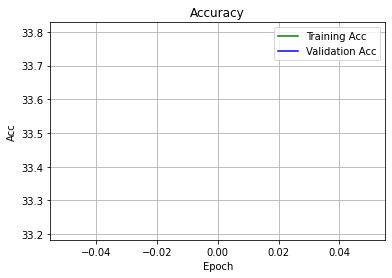

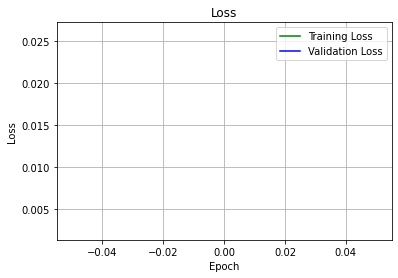

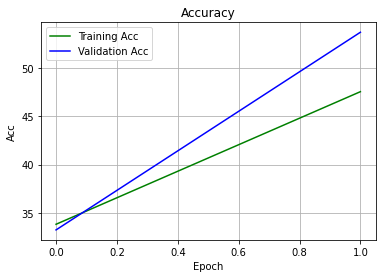

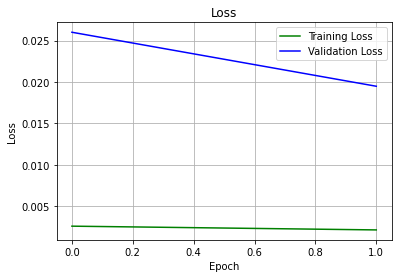

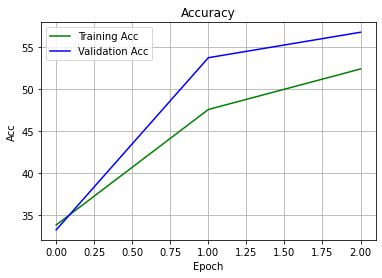

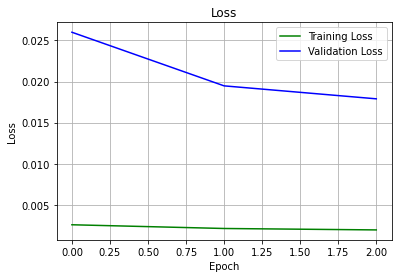

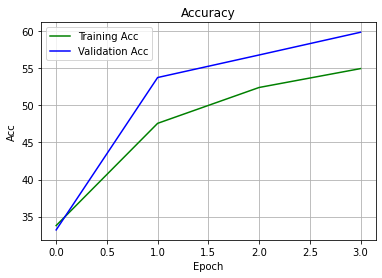

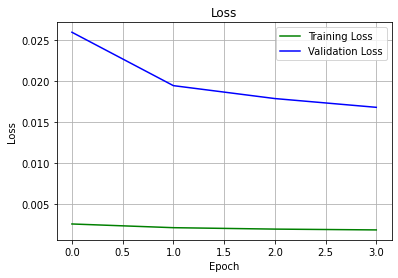

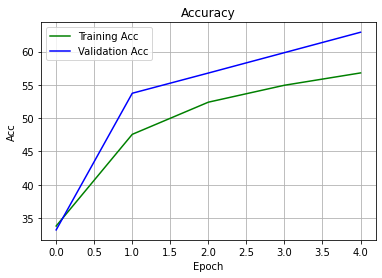

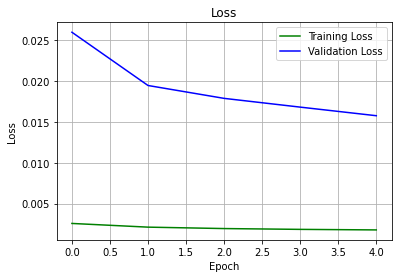

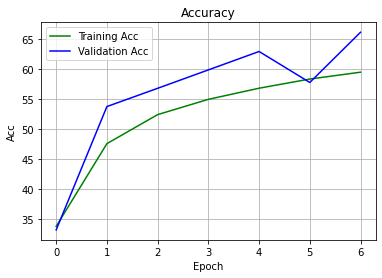

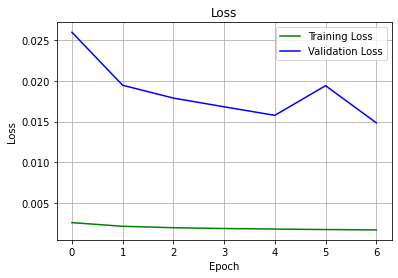

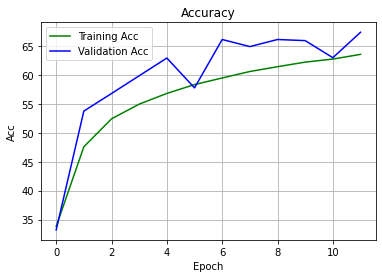

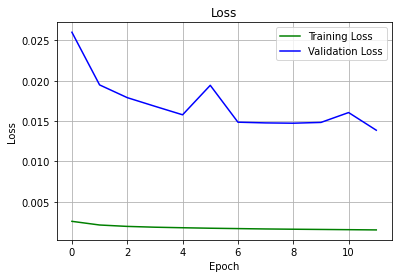

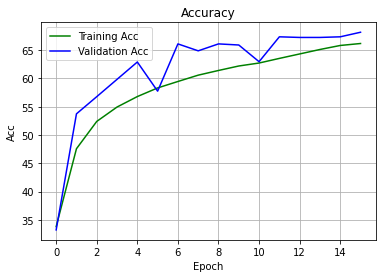

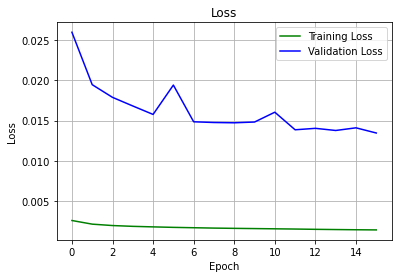

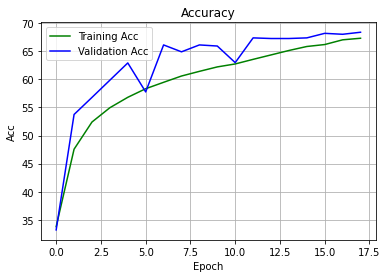

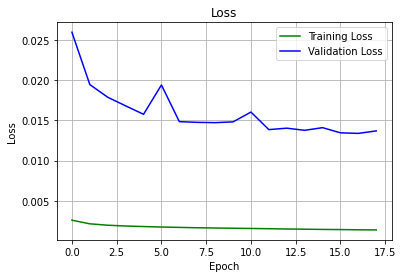

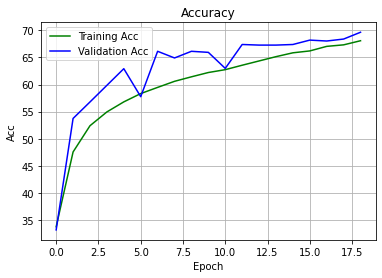

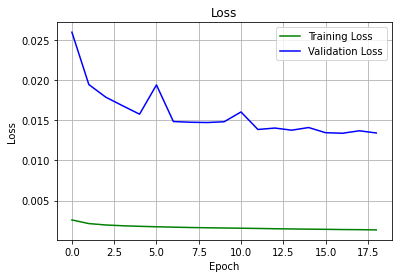

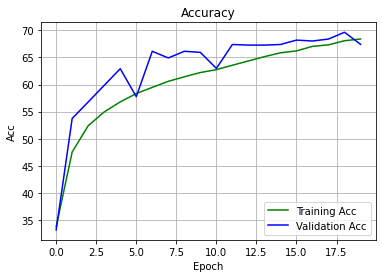

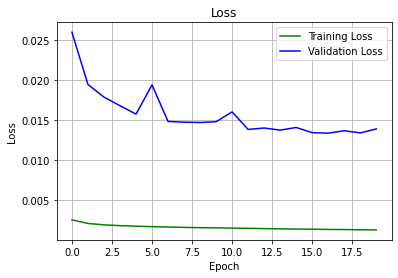

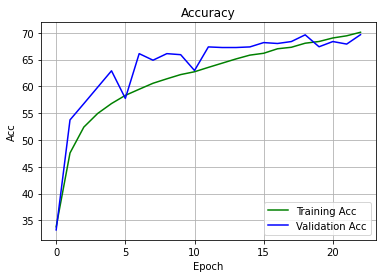

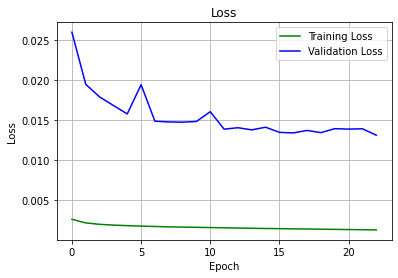

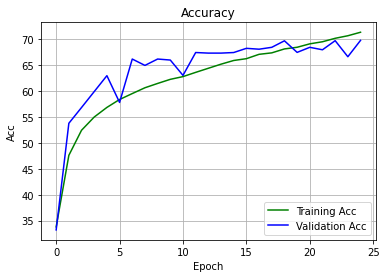

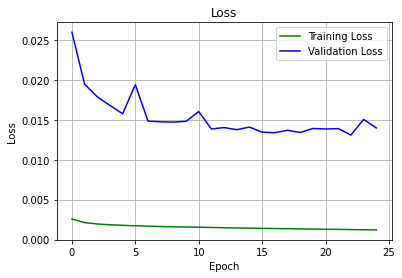

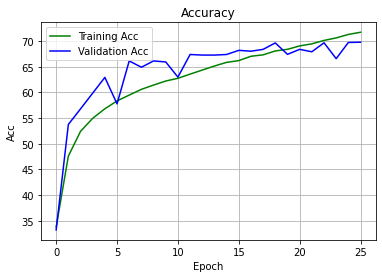

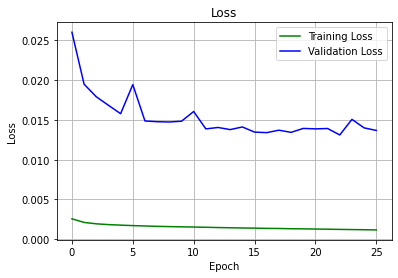

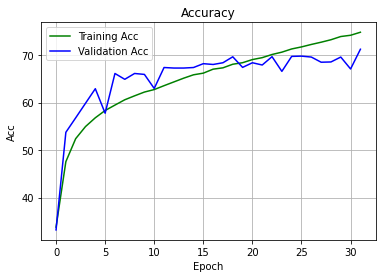

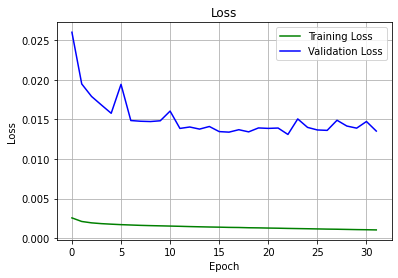

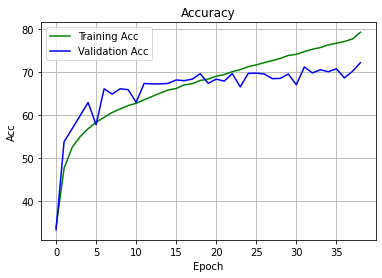

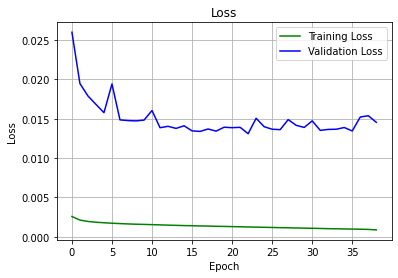

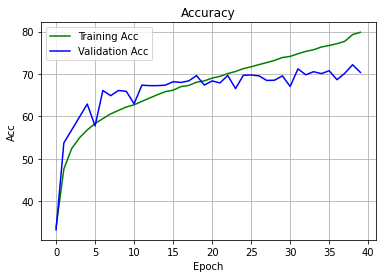

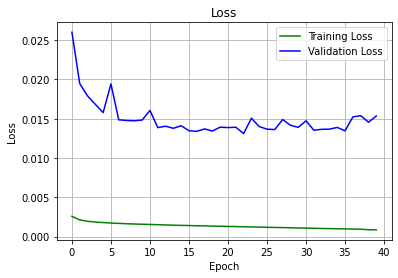

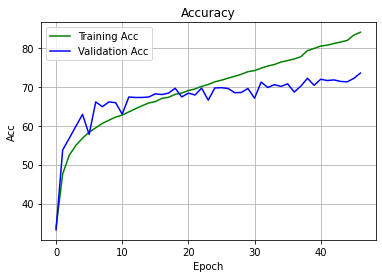

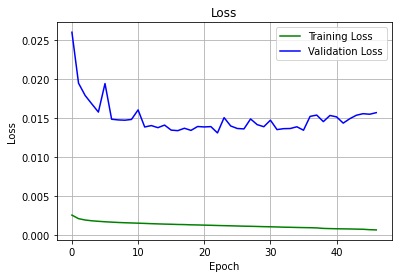

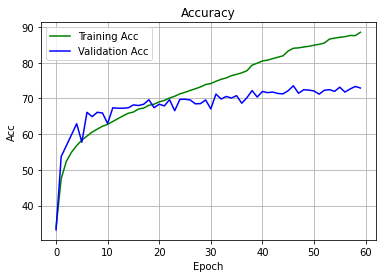

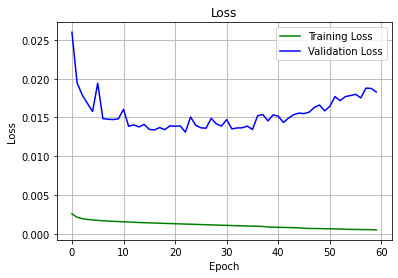

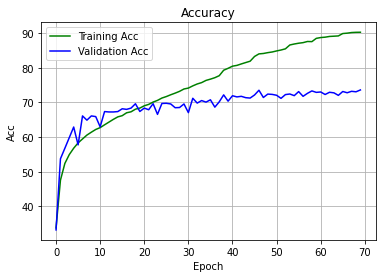

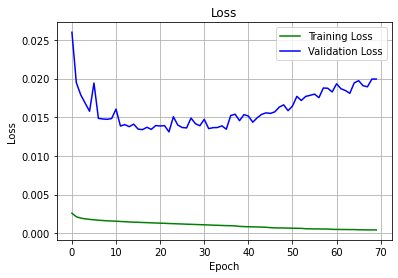

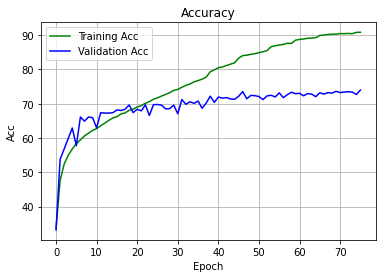

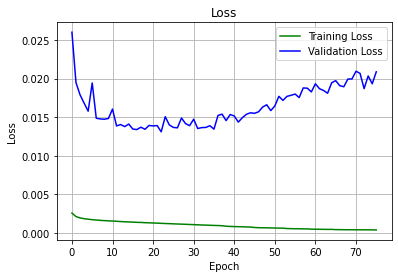

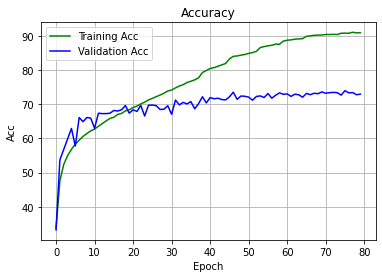

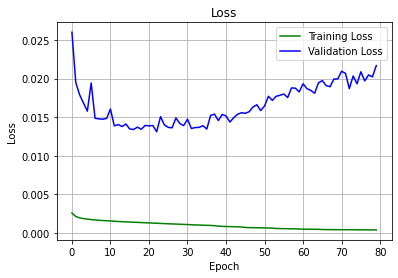

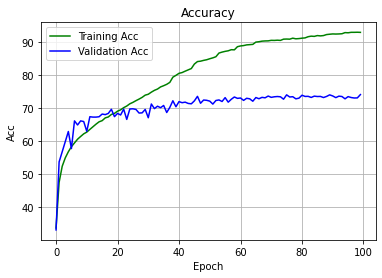

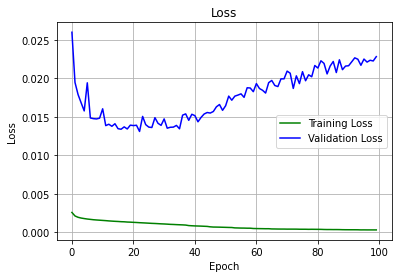

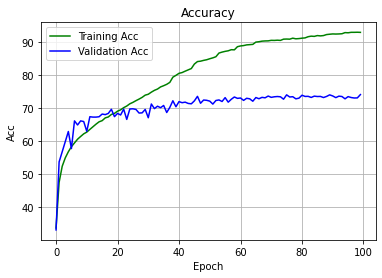

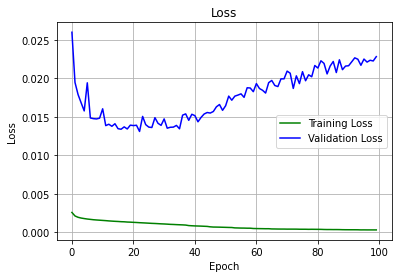

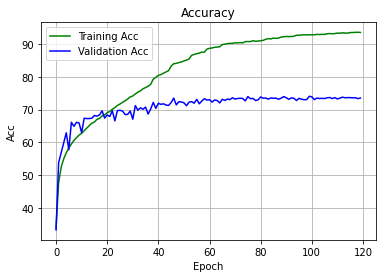

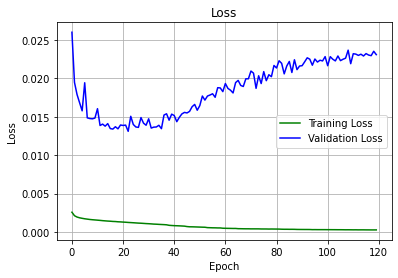

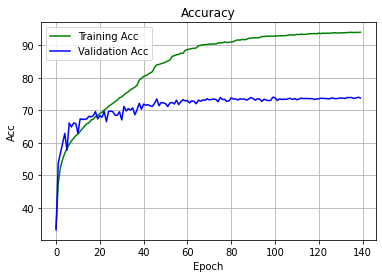

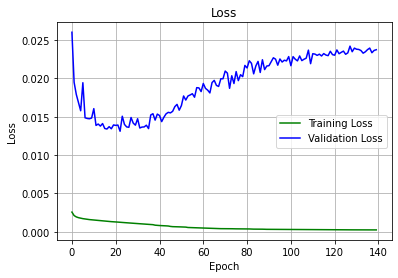

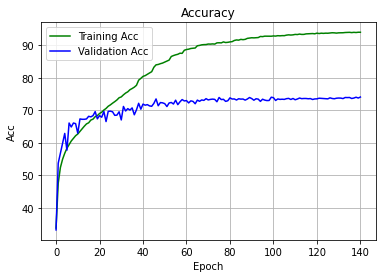

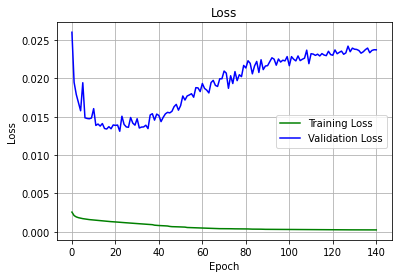

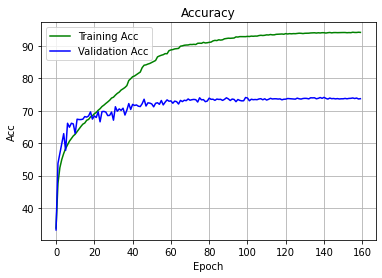

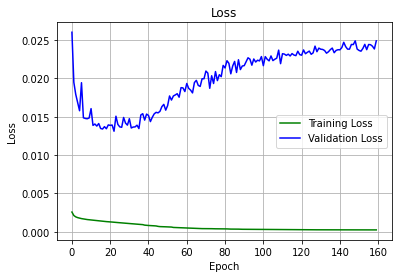

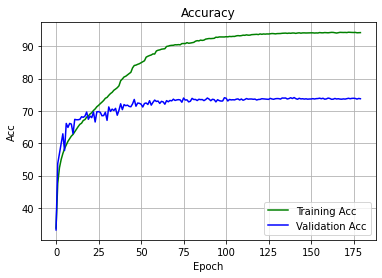

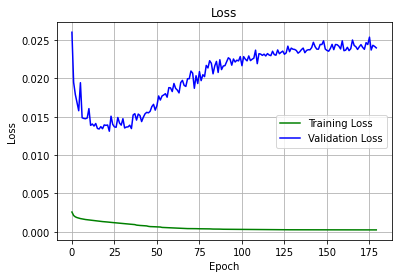

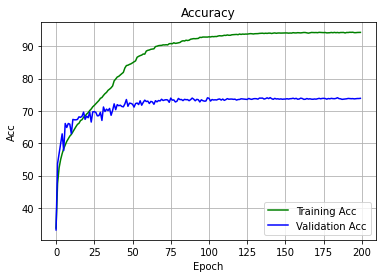

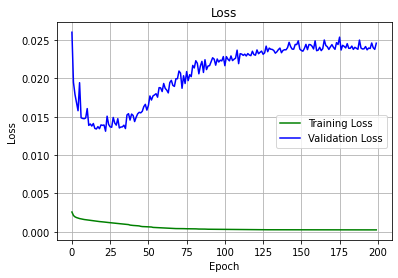

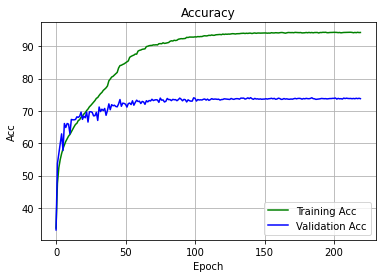

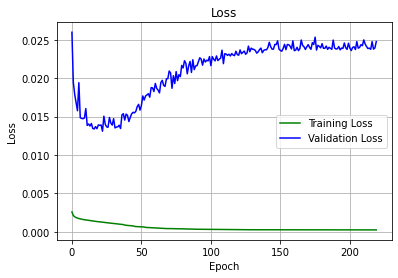

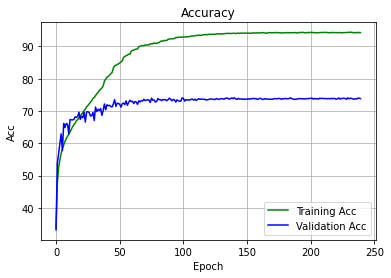

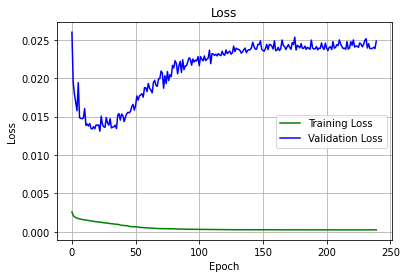

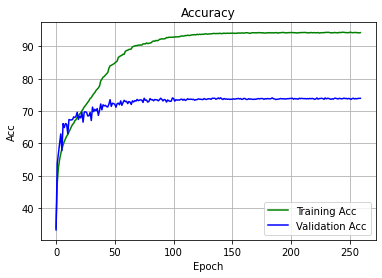

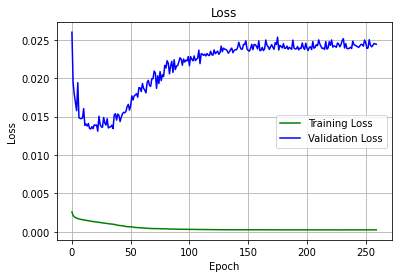

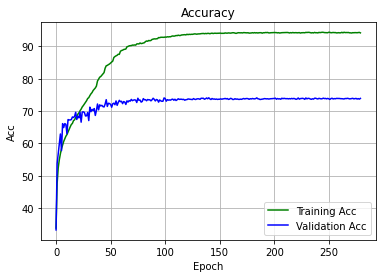

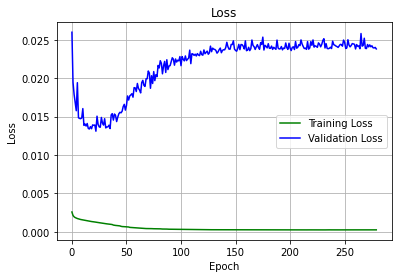

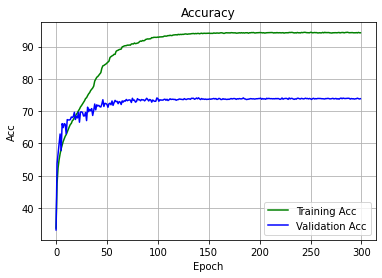

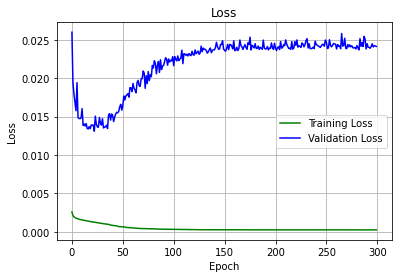

In [11]:
run(net, logger, hps)

# fine tuning

In [12]:
#50 epochs initial learning rate: 0.0001 scheduler:Consine Annealing
def run(net, logger, hps):
    # Create dataloaders
    trainloader, valloader, testloader = get_dataloaders(bs=hps['bs'])

    net = net.to(device)

    learning_rate = 0.0001
    scaler = GradScaler()

    # optimizer = torch.optim.Adadelta(net.parameters(), lr=learning_rate, weight_decay=0.0001)
    # optimizer = torch.optim.Adagrad(net.parameters(), lr=learning_rate, weight_decay=0.0001)
    # optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.0001, amsgrad=True)
    # optimizer = torch.optim.ASGD(net.parameters(), lr=learning_rate, weight_decay=0.0001)
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, nesterov=True, weight_decay=0.0001)

    #scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5, verbose=True)
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.5, last_epoch=-1, verbose=True)
    # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=hps['n_epochs'])
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6, last_epoch=-1, verbose=True)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6, last_epoch=-1, verbose=False)
    criterion = nn.CrossEntropyLoss()

    best_acc = 0.0

    print("Training", hps['name'], "on", device)
    for epoch in range(hps['start_epoch'], hps['n_epochs']):

        acc_tr, loss_tr = train(net, trainloader, criterion, optimizer, scaler)
        logger.loss_train.append(loss_tr)
        logger.acc_train.append(acc_tr)

        acc_v, loss_v = evaluate(net, valloader, criterion)
        logger.loss_val.append(loss_v)
        logger.acc_val.append(acc_v)

        # Update learning rate
        scheduler.step(acc_v)

        if acc_v > best_acc:
            best_acc = acc_v

            save(net, logger, hps, epoch + 1)
            logger.save_plt(hps)

        if (epoch + 1) % hps['save_freq'] == 0:
            save(net, logger, hps, epoch + 1)
            logger.save_plt(hps)

        print('Epoch %2d' % (epoch + 1),
              'Train Accuracy: %2.4f %%' % acc_tr,
              'Val Accuracy: %2.4f %%' % acc_v,
              sep='\t\t')

    # Calculate performance on test set
    acc_test, loss_test = evaluate(net, testloader, criterion)
    print('Test Accuracy: %2.4f %%' % acc_test,
          'Test Loss: %2.6f' % loss_test,
          sep='\t\t')

In [18]:
hps = {
    'network': 'vgg',  # which network do you want to train
    'name': 'myvgg',  # whatever you want to name your run
    'n_epochs': 350,
    'model_save_dir': None,  # where will checkpoints be stored (path created automatically using hps[name])
    'restore_epoch': 300,  # continue training from a specific saved point
    'start_epoch': 300,
    'lr': 0.0001,  # starting learning rate
    'save_freq': 10,  # how often to create checkpoints
    'drop': 0.1,
    'bs': 64,
}
hps['model_save_dir'] = os.path.join(os.getcwd(), 'result/best/second/', hps['name'])

if not os.path.exists(hps['model_save_dir']):
    os.makedirs(hps['model_save_dir'])
    

In [19]:
logger, net = setup_network(hps)
# Load Trained Model
checkpoint = torch.load('result/best/second/myvgg/epoch_300',map_location=torch.device('cpu'))
net = Vgg().to(device)
net.load_state_dict(checkpoint["params"])
net.eval()

Network Restored!


Vgg(
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4b): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1a): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2a): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn

Training myvgg on cuda:0
Epoch 301		Train Accuracy: 94.2774 %		Val Accuracy: 73.8089 %
Epoch 302		Train Accuracy: 94.3910 %		Val Accuracy: 73.8367 %
Epoch 303		Train Accuracy: 94.2088 %		Val Accuracy: 73.7810 %
Epoch 304		Train Accuracy: 94.2506 %		Val Accuracy: 73.8367 %
Epoch 305		Train Accuracy: 94.2468 %		Val Accuracy: 74.0318 %
Epoch 306		Train Accuracy: 94.3074 %		Val Accuracy: 74.0596 %
Epoch 307		Train Accuracy: 94.3425 %		Val Accuracy: 73.8924 %
Epoch 308		Train Accuracy: 94.2805 %		Val Accuracy: 73.8367 %
Epoch 309		Train Accuracy: 94.2422 %		Val Accuracy: 73.8089 %
Epoch 310		Train Accuracy: 94.1903 %		Val Accuracy: 73.8089 %
Epoch 311		Train Accuracy: 94.3143 %		Val Accuracy: 73.8646 %
Epoch 312		Train Accuracy: 94.2318 %		Val Accuracy: 73.8646 %
Epoch 313		Train Accuracy: 94.2387 %		Val Accuracy: 74.1154 %
Epoch 314		Train Accuracy: 94.2704 %		Val Accuracy: 73.7810 %
Epoch 315		Train Accuracy: 94.2687 %		Val Accuracy: 73.7253 %
Epoch 316		Train Accuracy: 94.3154 %		Val Acc

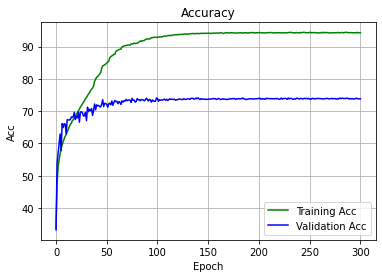

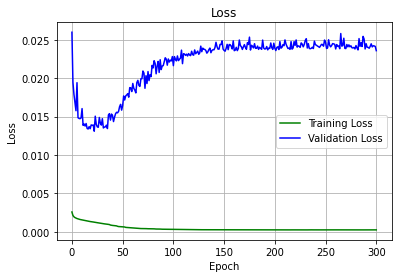

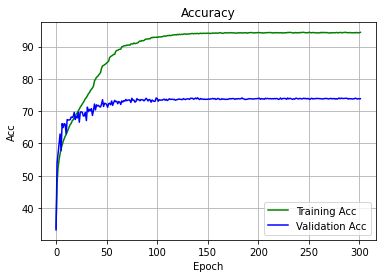

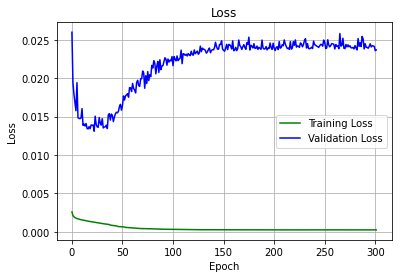

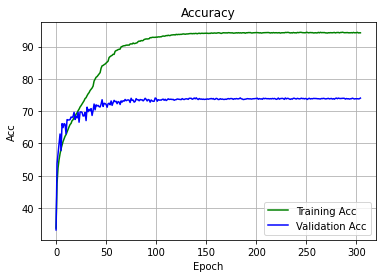

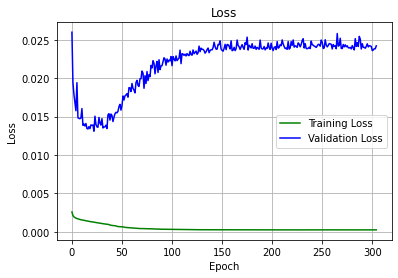

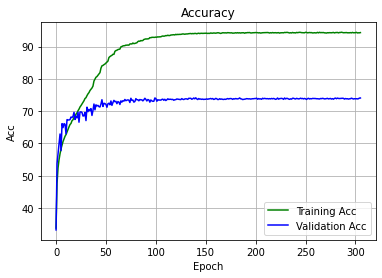

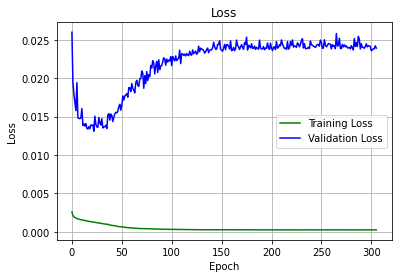

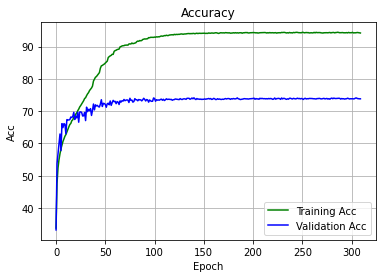

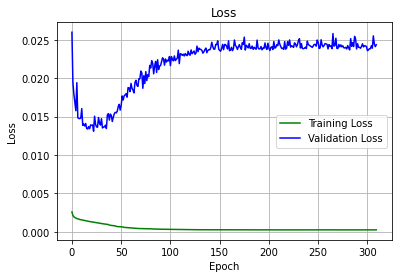

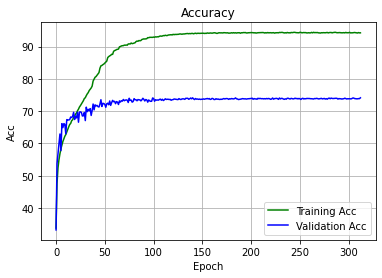

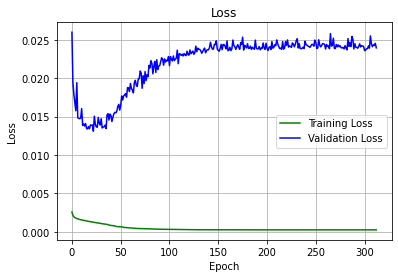

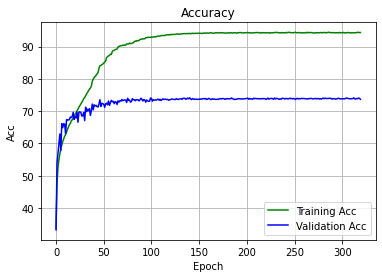

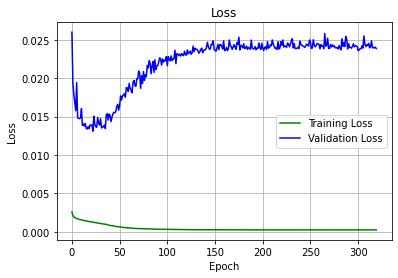

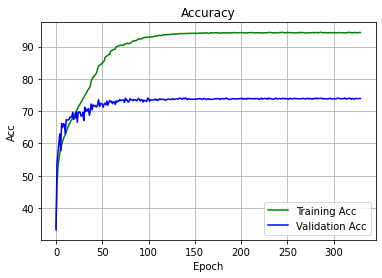

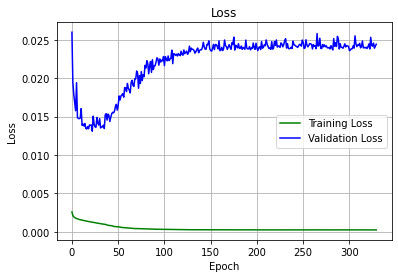

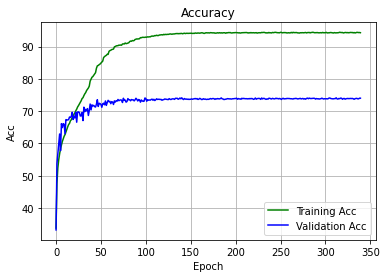

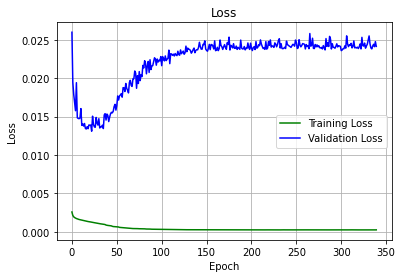

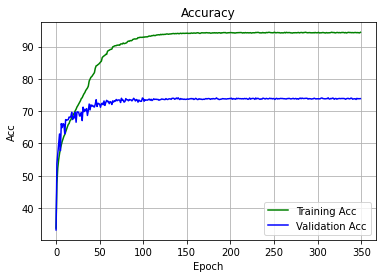

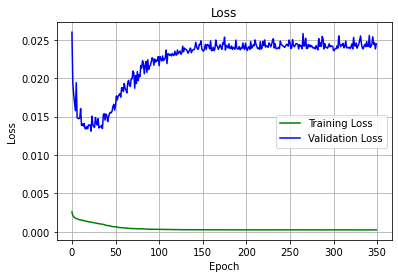

In [20]:
run(net, logger, hps)

# Fine tuning 2

In [21]:
#50 epochs initial learning rate: 0.0001 scheduler:Consine Annealing with Warm Restarts
def run(net, logger, hps):
    # Create dataloaders
    trainloader, valloader, testloader = get_dataloaders(bs=hps['bs'])

    net = net.to(device)

    learning_rate = 0.0001
    scaler = GradScaler()

    # optimizer = torch.optim.Adadelta(net.parameters(), lr=learning_rate, weight_decay=0.0001)
    # optimizer = torch.optim.Adagrad(net.parameters(), lr=learning_rate, weight_decay=0.0001)
    # optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.0001, amsgrad=True)
    # optimizer = torch.optim.ASGD(net.parameters(), lr=learning_rate, weight_decay=0.0001)
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, nesterov=True, weight_decay=0.0001)

    #scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5, verbose=True)
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.5, last_epoch=-1, verbose=True)
    # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=hps['n_epochs'])
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6, last_epoch=-1, verbose=True)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6, last_epoch=-1, verbose=False)
    criterion = nn.CrossEntropyLoss()

    best_acc = 0.0

    print("Training", hps['name'], "on", device)
    for epoch in range(hps['start_epoch'], hps['n_epochs']):

        acc_tr, loss_tr = train(net, trainloader, criterion, optimizer, scaler)
        logger.loss_train.append(loss_tr)
        logger.acc_train.append(acc_tr)

        acc_v, loss_v = evaluate(net, valloader, criterion)
        logger.loss_val.append(loss_v)
        logger.acc_val.append(acc_v)

        # Update learning rate
        scheduler.step(acc_v)

        if acc_v > best_acc:
            best_acc = acc_v

            save(net, logger, hps, epoch + 1)
            logger.save_plt(hps)

        if (epoch + 1) % hps['save_freq'] == 0:
            save(net, logger, hps, epoch + 1)
            logger.save_plt(hps)

        print('Epoch %2d' % (epoch + 1),
              'Train Accuracy: %2.4f %%' % acc_tr,
              'Val Accuracy: %2.4f %%' % acc_v,
              sep='\t\t')

    # Calculate performance on test set
    acc_test, loss_test = evaluate(net, testloader, criterion)
    print('Test Accuracy: %2.4f %%' % acc_test,
          'Test Loss: %2.6f' % loss_test,
          sep='\t\t')

In [22]:
hps = {
    'network': 'vgg',  # which network do you want to train
    'name': 'myvgg',  # whatever you want to name your run
    'n_epochs': 350,
    'model_save_dir': None,  # where will checkpoints be stored (path created automatically using hps[name])
    'restore_epoch': 300,  # continue training from a specific saved point
    'start_epoch': 300,
    'lr': 0.0001,  # starting learning rate
    'save_freq': 10,  # how often to create checkpoints
    'drop': 0.1,
    'bs': 64,
}
hps['model_save_dir'] = os.path.join(os.getcwd(), 'result/best/second/', hps['name'])

if not os.path.exists(hps['model_save_dir']):
    os.makedirs(hps['model_save_dir'])
    

In [24]:
logger, net = setup_network(hps)
# Load Trained Model
checkpoint = torch.load('result/best/second/myvgg/epoch_300',map_location=torch.device('cpu'))
net = Vgg().to(device)
net.load_state_dict(checkpoint["params"])
net.eval()

Network Restored!


Vgg(
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4b): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1a): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2a): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn

Epoch     0: adjusting learning rate of group 0 to 1.0000e-04.
Training myvgg on cuda:0
Epoch 301		Train Accuracy: 94.1419 %		Val Accuracy: 73.8646 %
Epoch 302		Train Accuracy: 94.3067 %		Val Accuracy: 73.6695 %
Epoch 303		Train Accuracy: 94.2391 %		Val Accuracy: 74.0039 %
Epoch 304		Train Accuracy: 94.3248 %		Val Accuracy: 73.9203 %
Epoch 305		Train Accuracy: 94.1736 %		Val Accuracy: 73.9482 %
Epoch 306		Train Accuracy: 94.2485 %		Val Accuracy: 73.8367 %
Epoch 307		Train Accuracy: 94.1907 %		Val Accuracy: 73.8646 %
Epoch 308		Train Accuracy: 94.3161 %		Val Accuracy: 73.8924 %
Epoch 309		Train Accuracy: 94.2983 %		Val Accuracy: 73.7531 %
Epoch 310		Train Accuracy: 94.3140 %		Val Accuracy: 73.9203 %
Epoch 311		Train Accuracy: 94.2983 %		Val Accuracy: 73.7531 %
Epoch 312		Train Accuracy: 94.2036 %		Val Accuracy: 73.8367 %
Epoch 313		Train Accuracy: 94.2091 %		Val Accuracy: 73.7253 %
Epoch 314		Train Accuracy: 94.2415 %		Val Accuracy: 73.6138 %
Epoch 315		Train Accuracy: 94.2468 %		Val Ac

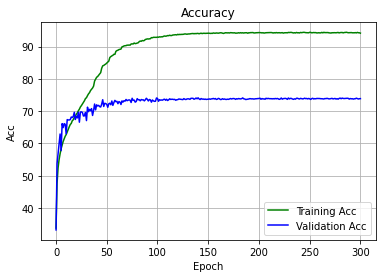

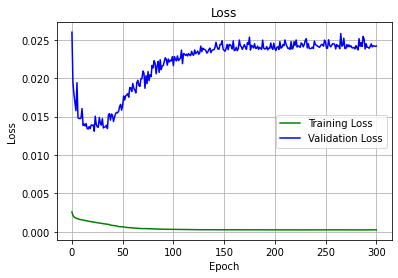

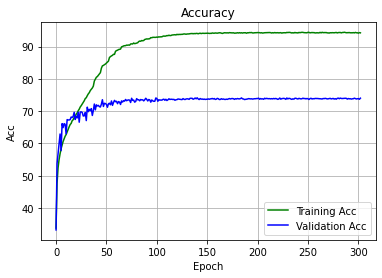

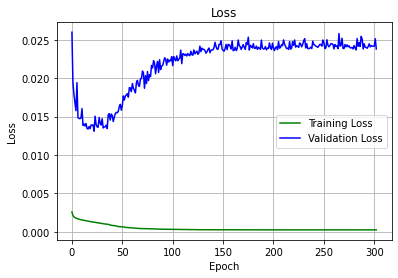

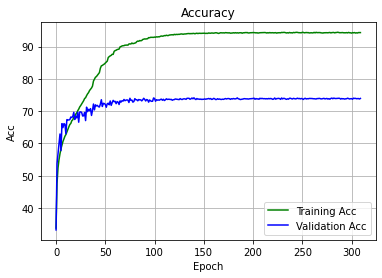

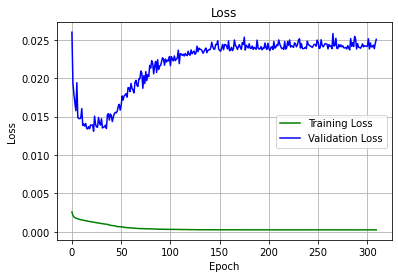

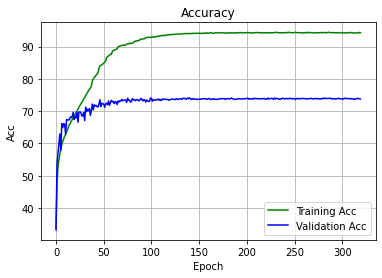

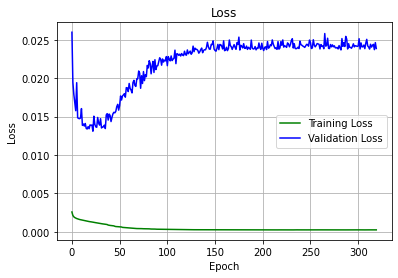

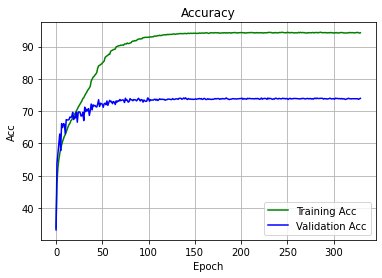

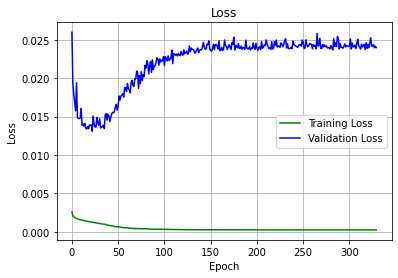

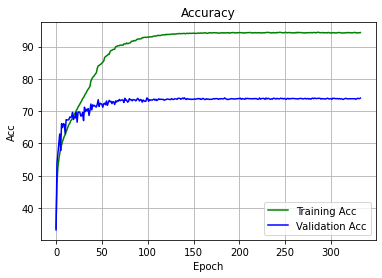

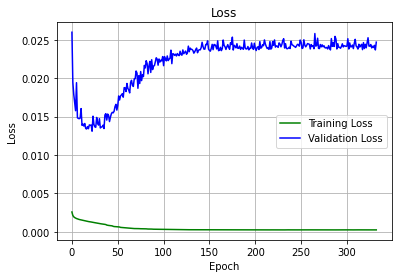

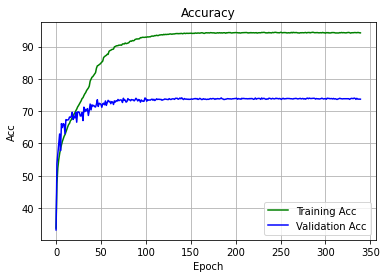

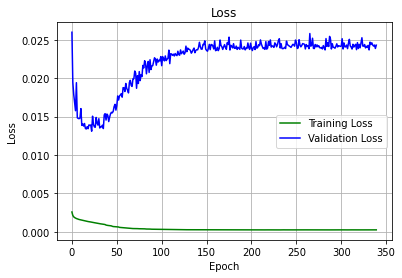

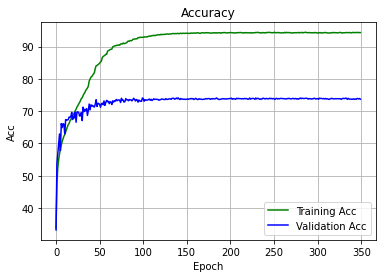

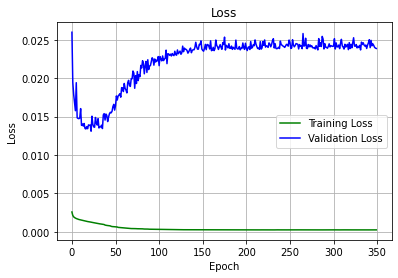

In [25]:
run(net, logger, hps)

In [11]:
import numpy as np
import pandas as pd
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None, augment=False):
        self.images = images
        self.labels = labels
        self.transform = transform

        self.augment = augment

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = np.array(self.images[idx])

        img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.labels[idx]).type(torch.long)
        sample = (img, label)

        return sample
    
def load_data(path='datasets/fer2013/fer2013.csv'):
    fer2013 = pd.read_csv(path)
    emotion_mapping = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

    return fer2013, emotion_mapping


def prepare_data(data):
    """ Prepare data for modeling
        input: data frame with labels und pixel data
        output: image and label array """

    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

def get_dataloaders(path='datasets/fer2013/fer2013.csv', bs=64, augment=True):
    """ Prepare train, val, & test dataloaders
        Augment training data using:
            - cropping
            - shifting (vertical/horizental)
            - horizental flipping
            - rotation

        input: path to fer2013 csv file
        output: (Dataloader, Dataloader, Dataloader) """

    fer2013, emotion_mapping = load_data(path)

    xtrain, ytrain = prepare_data(fer2013[fer2013['Usage'] == 'Training'])
    xval, yval = prepare_data(fer2013[fer2013['Usage'] == 'PrivateTest'])
    xtest, ytest = prepare_data(fer2013[fer2013['Usage'] == 'PublicTest'])

    mu, st = 0, 255

    test_transform = transforms.Compose([
        # transforms.Scale(52),
        transforms.TenCrop(40),
        transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
        transforms.Lambda(lambda tensors: torch.stack([transforms.Normalize(mean=(mu,), std=(st,))(t) for t in tensors])),
    ])

    if augment:
        train_transform = transforms.Compose([
            transforms.RandomResizedCrop(48, scale=(0.8, 1.2)),
            transforms.RandomApply([transforms.RandomAffine(0, translate=(0.2, 0.2))], p=0.5),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([transforms.RandomRotation(10)], p=0.5),

            transforms.TenCrop(40),
            transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
            transforms.Lambda(lambda tensors: torch.stack([transforms.Normalize(mean=(mu,), std=(st,))(t) for t in tensors])),
            transforms.Lambda(lambda tensors: torch.stack([transforms.RandomErasing(p=0.5)(t) for t in tensors])),
        ])
    else:
        train_transform = test_transform

    # X = np.vstack((xtrain, xval))
    # Y = np.hstack((ytrain, yval))

    train = CustomDataset(xtrain, ytrain, train_transform) + CustomDataset(xval, yval, test_transform)
    val = CustomDataset(xval, yval, test_transform)
    test = CustomDataset(xtest, ytest, test_transform)

    trainloader = DataLoader(train, batch_size=bs, shuffle=True, num_workers=2)
    valloader = DataLoader(val, batch_size=64, shuffle=True, num_workers=2)
    testloader = DataLoader(test, batch_size=64, shuffle=True, num_workers=2)

    return trainloader, valloader, testloader

In [12]:
#50 epochs initial learning rate: 0.0001 scheduler:Consine Annealing
def run(net, logger, hps):
    # Create dataloaders
    trainloader, valloader, testloader = get_dataloaders(bs=hps['bs'])

    net = net.to(device)

    learning_rate = 0.0001
    scaler = GradScaler()

    # optimizer = torch.optim.Adadelta(net.parameters(), lr=learning_rate, weight_decay=0.0001)
    # optimizer = torch.optim.Adagrad(net.parameters(), lr=learning_rate, weight_decay=0.0001)
    # optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.0001, amsgrad=True)
    # optimizer = torch.optim.ASGD(net.parameters(), lr=learning_rate, weight_decay=0.0001)
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, nesterov=True, weight_decay=0.0001)

    #scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5, verbose=True)
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.5, last_epoch=-1, verbose=True)
    # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=hps['n_epochs'])
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6, last_epoch=-1, verbose=True)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6, last_epoch=-1, verbose=False)
    criterion = nn.CrossEntropyLoss()

    best_acc = 0.0

    print("Training", hps['name'], "on", device)
    for epoch in range(hps['start_epoch'], hps['n_epochs']):

        acc_tr, loss_tr = train(net, trainloader, criterion, optimizer, scaler)
        logger.loss_train.append(loss_tr)
        logger.acc_train.append(acc_tr)

        acc_v, loss_v = evaluate(net, valloader, criterion)
        logger.loss_val.append(loss_v)
        logger.acc_val.append(acc_v)

        # Update learning rate
        scheduler.step(acc_v)

        if acc_v > best_acc:
            best_acc = acc_v

            save(net, logger, hps, epoch + 1)
            logger.save_plt(hps)

        if (epoch + 1) % hps['save_freq'] == 0:
            save(net, logger, hps, epoch + 1)
            logger.save_plt(hps)

        print('Epoch %2d' % (epoch + 1),
              'Train Accuracy: %2.4f %%' % acc_tr,
              'Val Accuracy: %2.4f %%' % acc_v,
              sep='\t\t')

    # Calculate performance on test set
    acc_test, loss_test = evaluate(net, testloader, criterion)
    print('Test Accuracy: %2.4f %%' % acc_test,
          'Test Loss: %2.6f' % loss_test,
          sep='\t\t')

In [13]:
hps = {
    'network': 'vgg',  # which network do you want to train
    'name': 'myvgg',  # whatever you want to name your run
    'n_epochs': 350,
    'model_save_dir': None,  # where will checkpoints be stored (path created automatically using hps[name])
    'restore_epoch': 300,  # continue training from a specific saved point
    'start_epoch': 300,
    'lr': 0.0001,  # starting learning rate
    'save_freq': 10,  # how often to create checkpoints
    'drop': 0.1,
    'bs': 64,
}
hps['model_save_dir'] = os.path.join(os.getcwd(), 'result/best/second', hps['name'])

if not os.path.exists(hps['model_save_dir']):
    os.makedirs(hps['model_save_dir'])
    

In [14]:
logger, net = setup_network(hps)
# Load Trained Model
checkpoint = torch.load('result/best/second/myvgg/epoch_300',map_location=torch.device('cpu'))
net = Vgg().to(device)
net.load_state_dict(checkpoint["params"])
net.eval()

Network Restored!


Vgg(
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4b): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1a): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2a): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn

Training myvgg on cuda:0
Epoch 301		Train Accuracy: 91.5877 %		Val Accuracy: 75.5642 %
Epoch 302		Train Accuracy: 91.6961 %		Val Accuracy: 76.4558 %
Epoch 303		Train Accuracy: 91.7812 %		Val Accuracy: 77.2639 %
Epoch 304		Train Accuracy: 91.7376 %		Val Accuracy: 78.4620 %
Epoch 305		Train Accuracy: 91.9320 %		Val Accuracy: 79.4650 %
Epoch 306		Train Accuracy: 91.9419 %		Val Accuracy: 80.3566 %
Epoch 307		Train Accuracy: 92.1150 %		Val Accuracy: 81.6105 %
Epoch 308		Train Accuracy: 92.1246 %		Val Accuracy: 82.4742 %
Epoch 309		Train Accuracy: 92.3336 %		Val Accuracy: 83.4216 %
Epoch 310		Train Accuracy: 92.4234 %		Val Accuracy: 84.3132 %
Epoch 311		Train Accuracy: 92.4658 %		Val Accuracy: 84.7311 %
Epoch 312		Train Accuracy: 92.4494 %		Val Accuracy: 85.4834 %
Epoch 313		Train Accuracy: 92.5101 %		Val Accuracy: 86.0128 %
Epoch 314		Train Accuracy: 92.6138 %		Val Accuracy: 86.3750 %
Epoch 315		Train Accuracy: 92.6927 %		Val Accuracy: 86.5143 %
Epoch 316		Train Accuracy: 92.6274 %		Val Acc

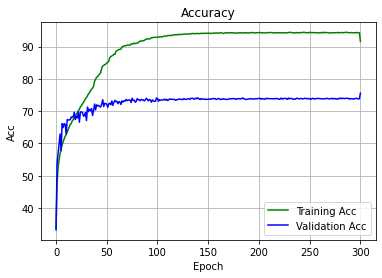

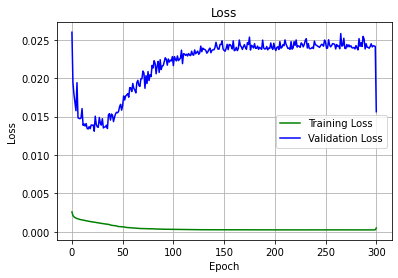

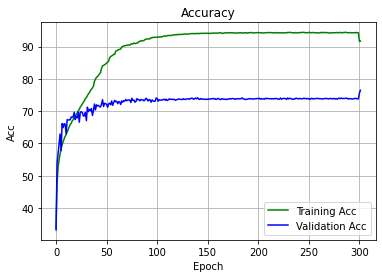

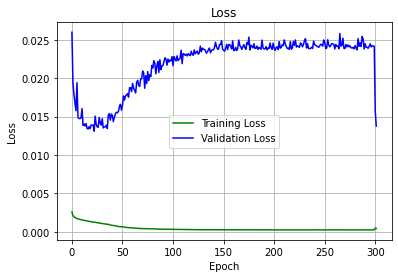

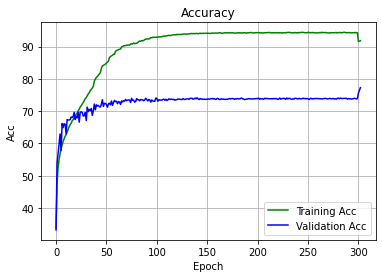

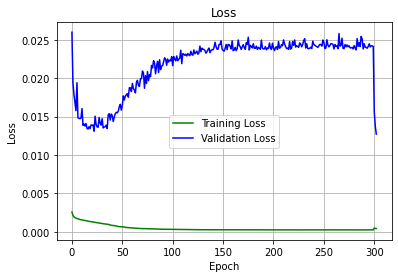

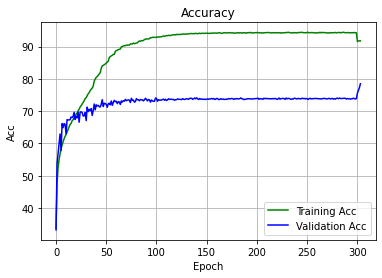

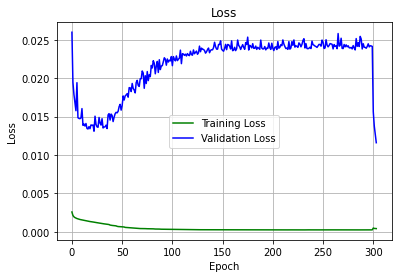

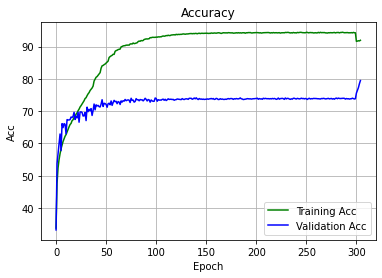

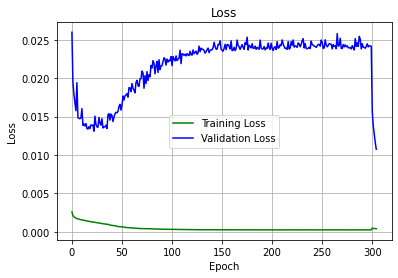

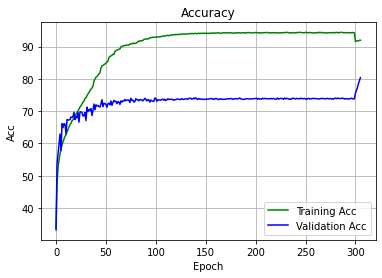

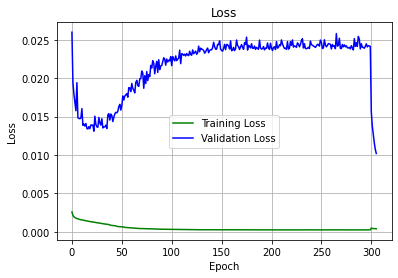

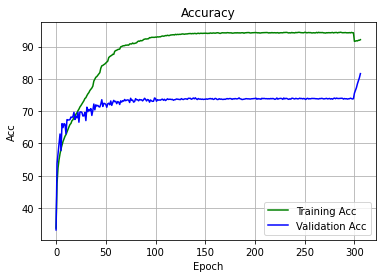

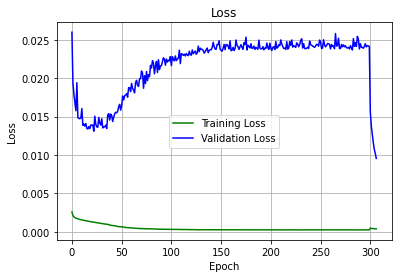

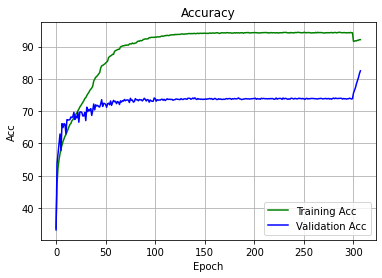

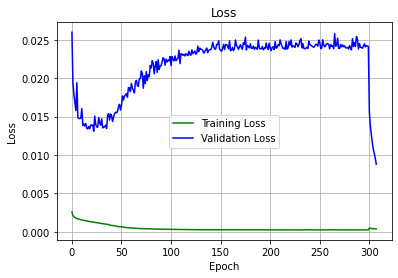

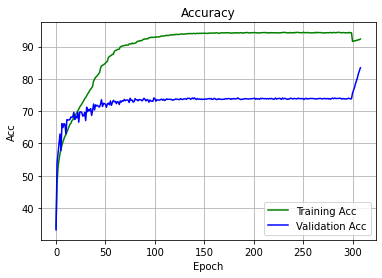

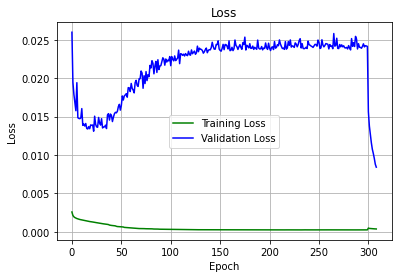

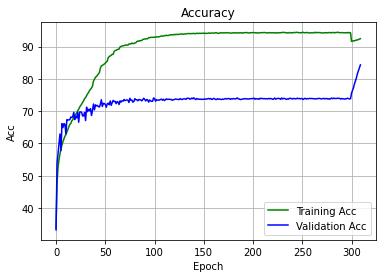

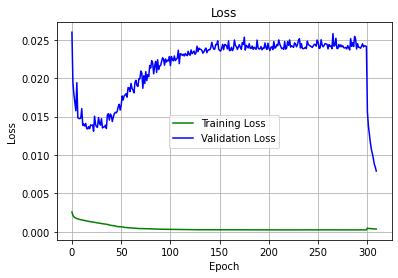

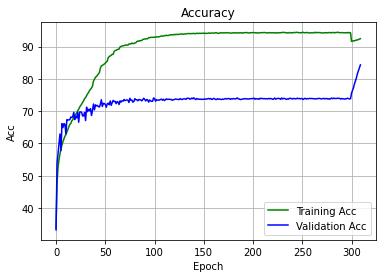

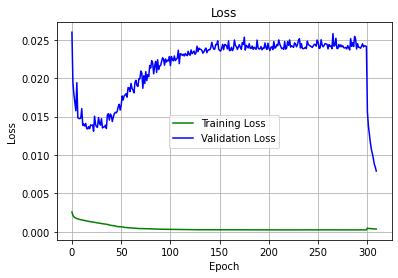

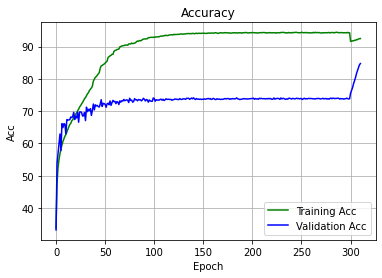

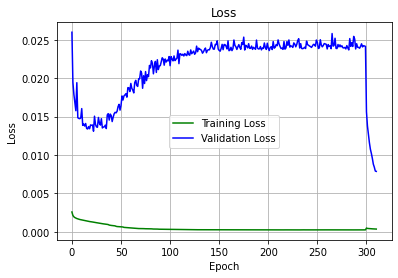

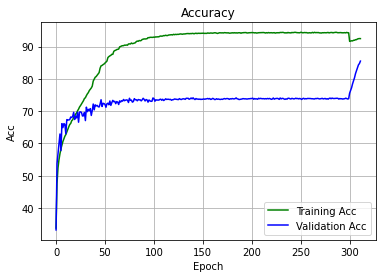

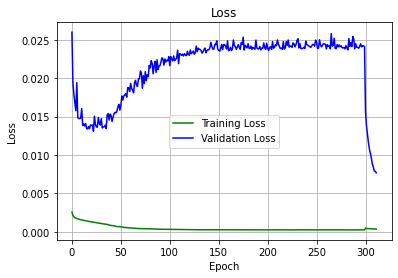

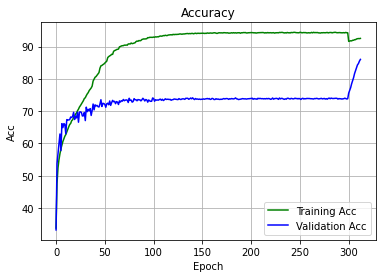

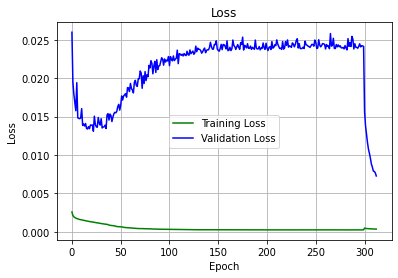

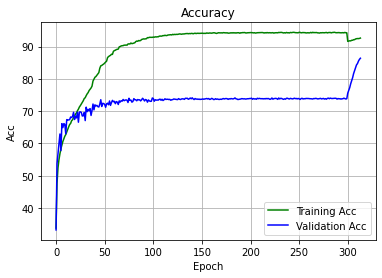

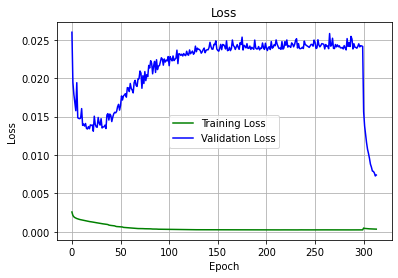

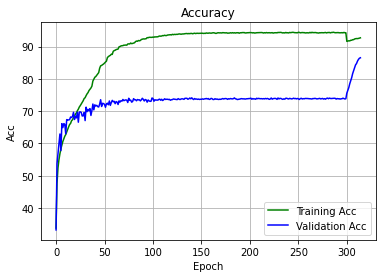

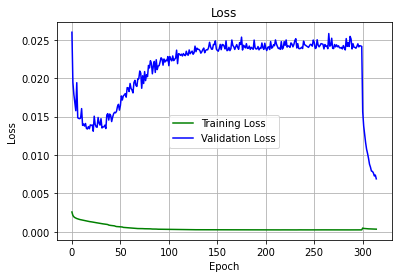

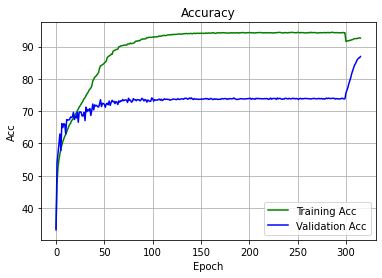

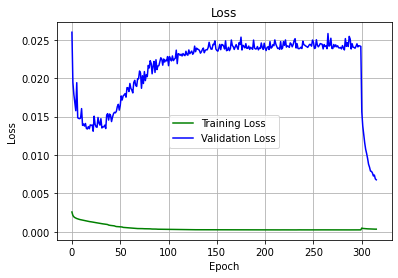

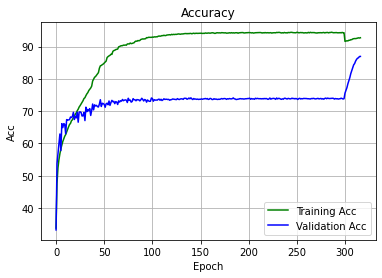

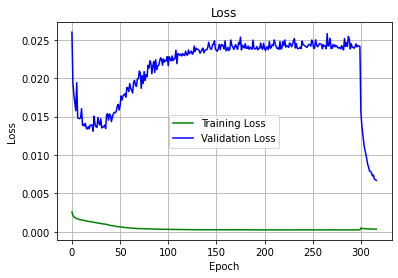

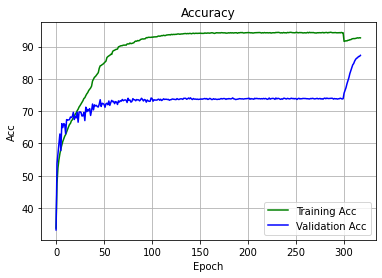

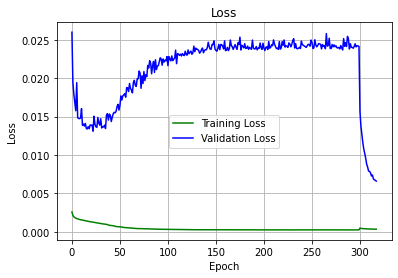

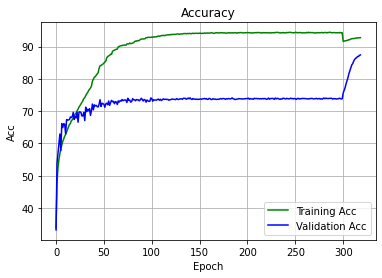

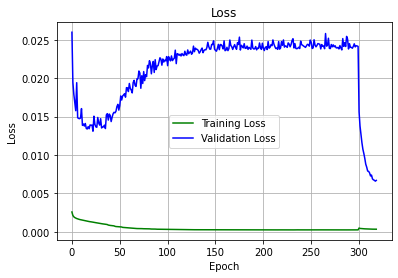

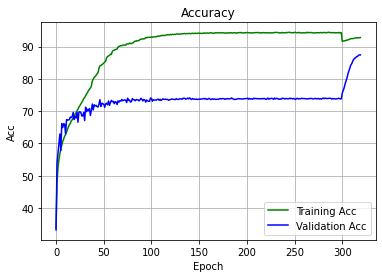

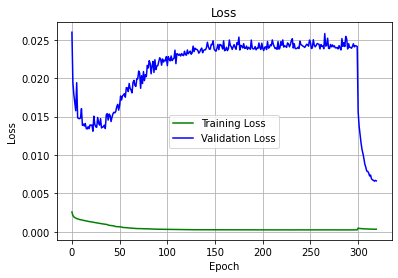

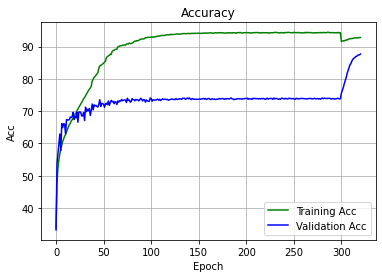

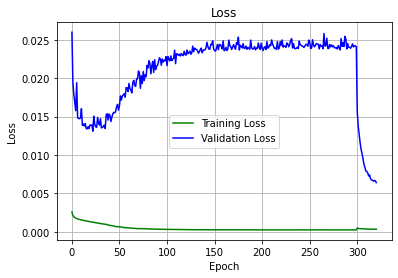

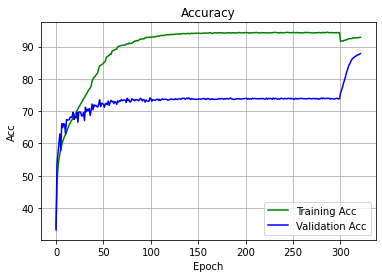

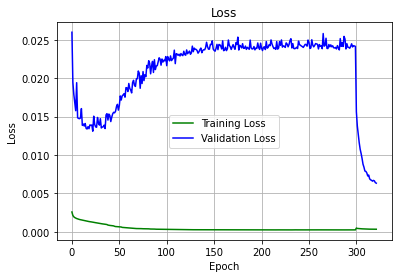

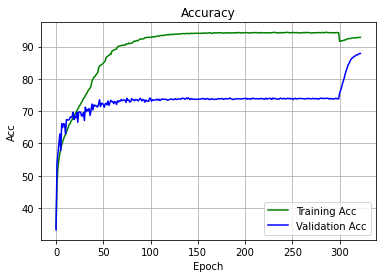

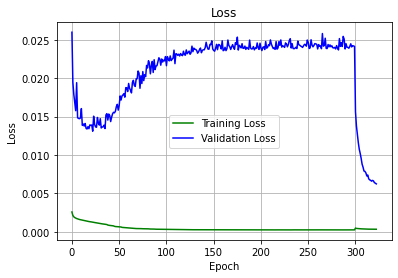

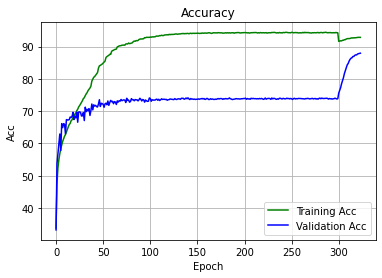

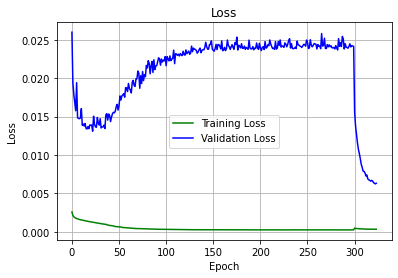

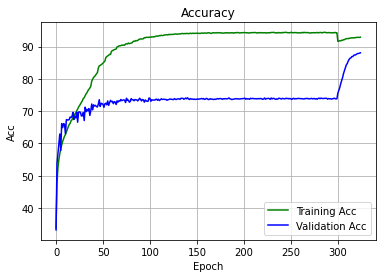

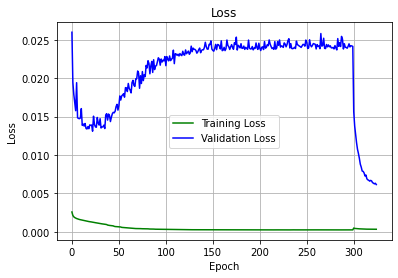

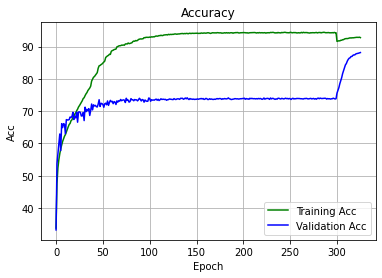

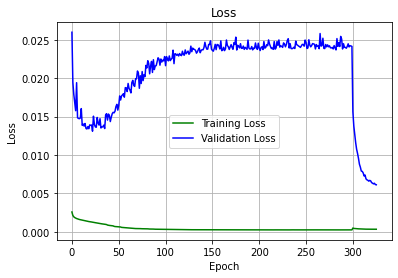

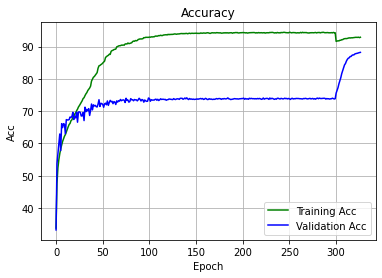

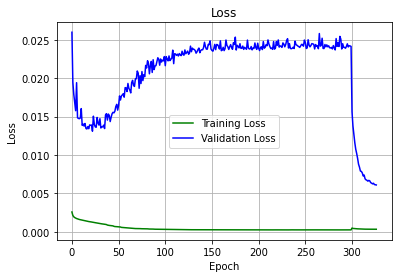

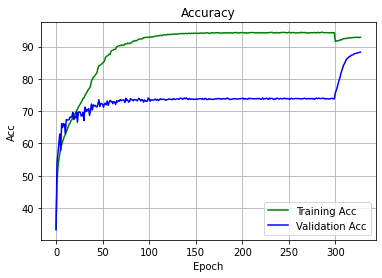

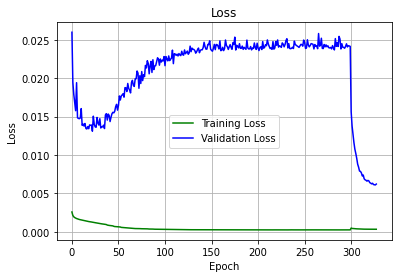

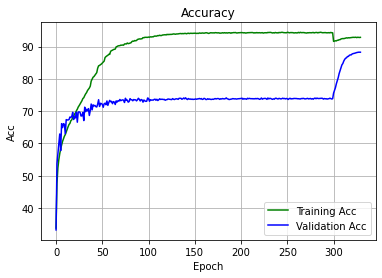

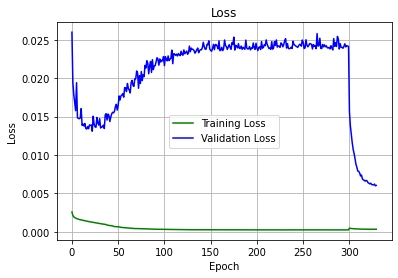

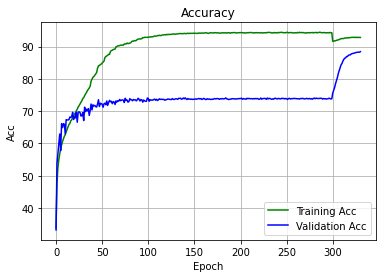

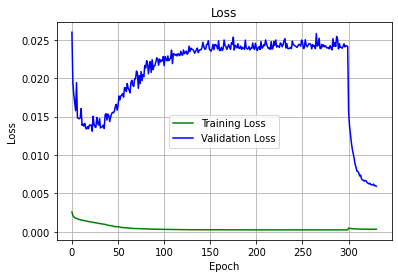

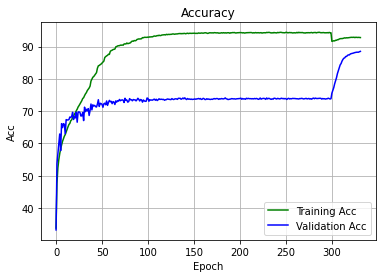

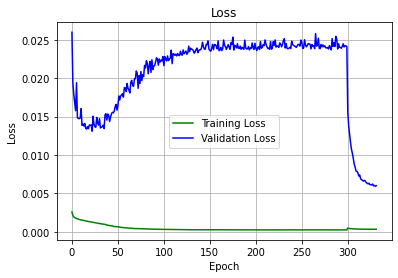

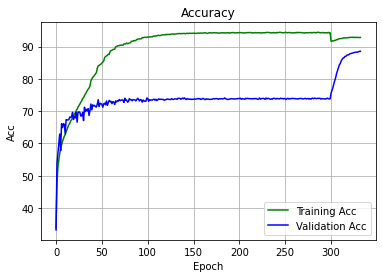

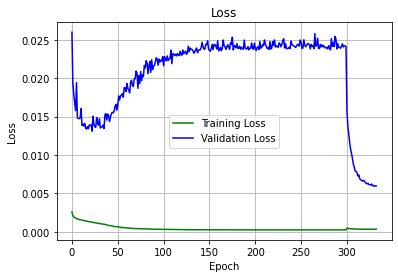

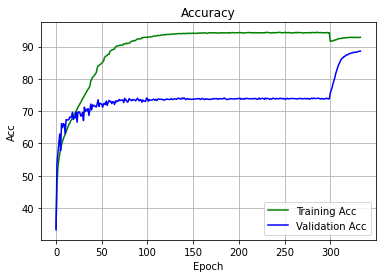

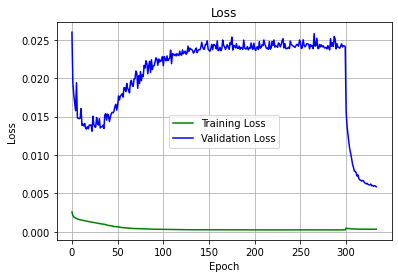

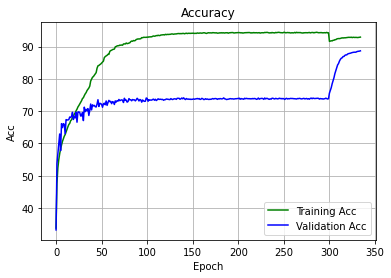

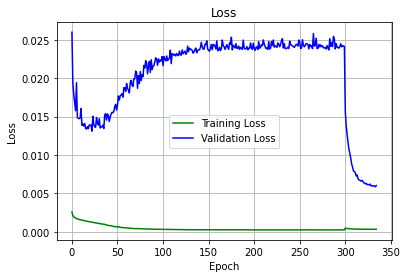

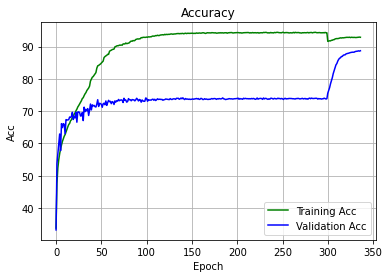

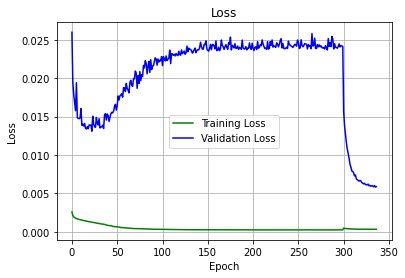

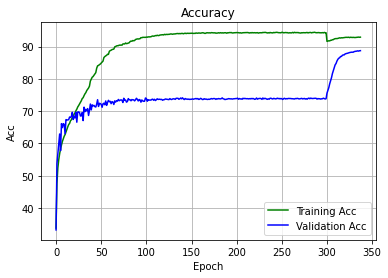

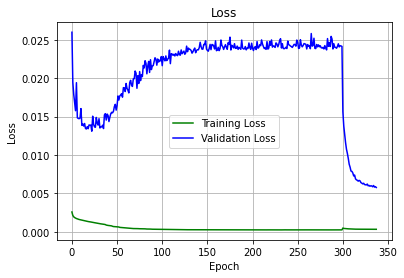

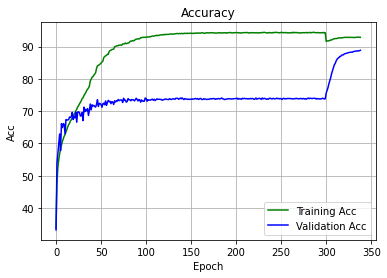

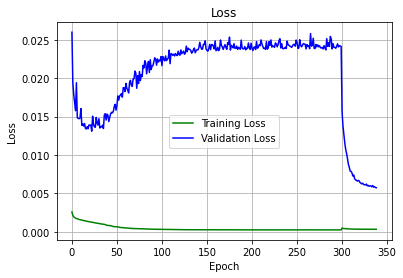

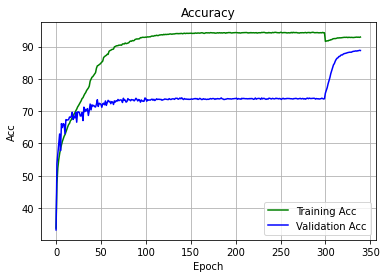

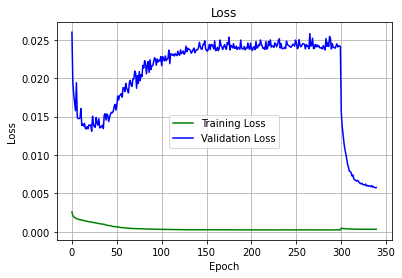

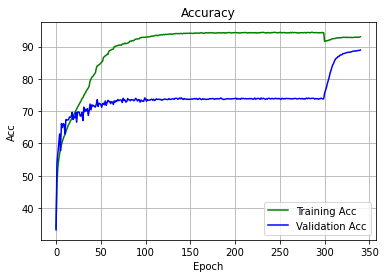

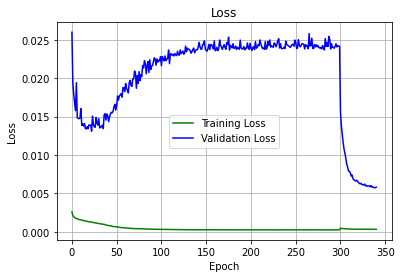

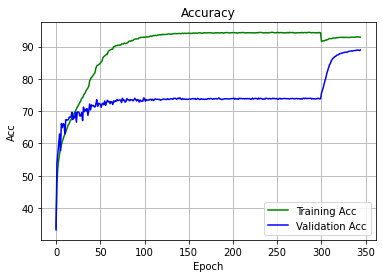

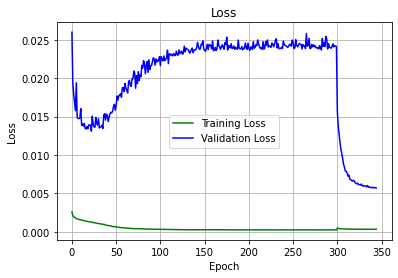

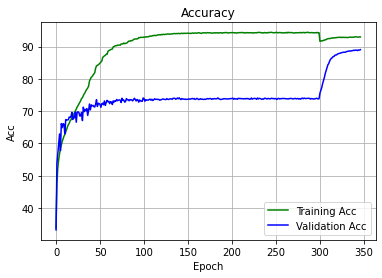

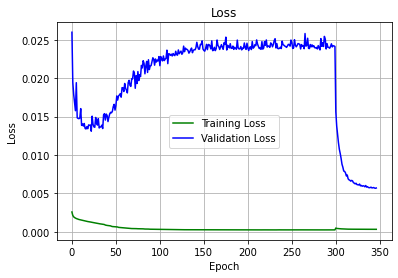

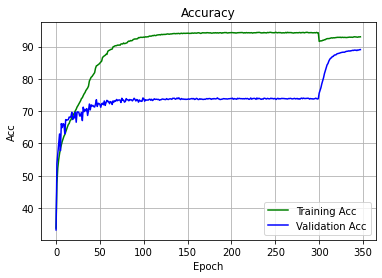

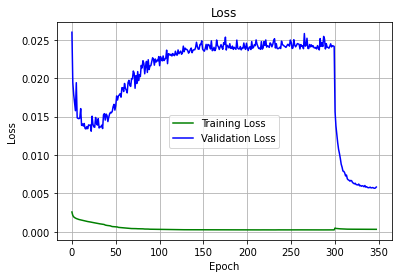

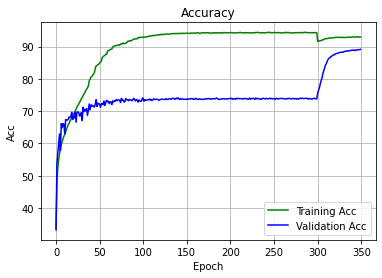

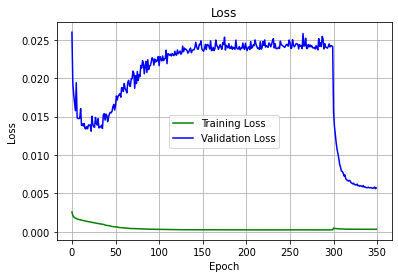

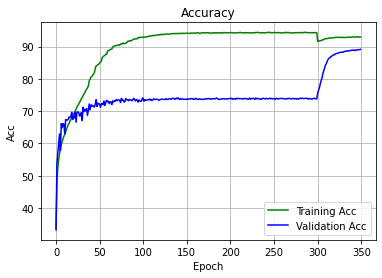

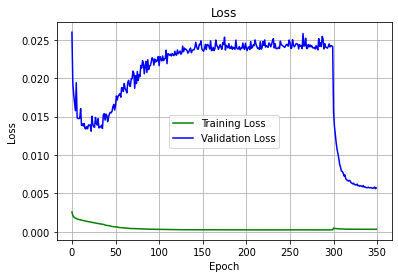

In [15]:
run(net, logger, hps)

In [16]:
import numpy as np
import pandas as pd
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None, augment=False):
        self.images = images
        self.labels = labels
        self.transform = transform

        self.augment = augment

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = np.array(self.images[idx])

        img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.labels[idx]).type(torch.long)
        sample = (img, label)

        return sample
    
def load_data(path='datasets/fer2013/fer2013.csv'):
    fer2013 = pd.read_csv(path)
    emotion_mapping = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

    return fer2013, emotion_mapping


def prepare_data(data):
    """ Prepare data for modeling
        input: data frame with labels und pixel data
        output: image and label array """

    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

def get_dataloaders(path='datasets/fer2013/fer2013.csv', bs=64, augment=True):
    """ Prepare train, val, & test dataloaders
        Augment training data using:
            - cropping
            - shifting (vertical/horizental)
            - horizental flipping
            - rotation

        input: path to fer2013 csv file
        output: (Dataloader, Dataloader, Dataloader) """

    fer2013, emotion_mapping = load_data(path)

    xtrain, ytrain = prepare_data(fer2013[fer2013['Usage'] == 'Training'])
    xval, yval = prepare_data(fer2013[fer2013['Usage'] == 'PrivateTest'])
    xtest, ytest = prepare_data(fer2013[fer2013['Usage'] == 'PublicTest'])

    mu, st = 0, 255

    test_transform = transforms.Compose([
        # transforms.Scale(52),
        transforms.TenCrop(40),
        transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
        transforms.Lambda(lambda tensors: torch.stack([transforms.Normalize(mean=(mu,), std=(st,))(t) for t in tensors])),
    ])

    if augment:
        train_transform = transforms.Compose([
            transforms.RandomResizedCrop(48, scale=(0.8, 1.2)),
            transforms.RandomApply([transforms.RandomAffine(0, translate=(0.2, 0.2))], p=0.5),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([transforms.RandomRotation(10)], p=0.5),

            transforms.TenCrop(40),
            transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
            transforms.Lambda(lambda tensors: torch.stack([transforms.Normalize(mean=(mu,), std=(st,))(t) for t in tensors])),
            transforms.Lambda(lambda tensors: torch.stack([transforms.RandomErasing(p=0.5)(t) for t in tensors])),
        ])
    else:
        train_transform = test_transform

    # X = np.vstack((xtrain, xval))
    # Y = np.hstack((ytrain, yval))

    train = CustomDataset(xtrain, ytrain, train_transform) + CustomDataset(xval, yval, test_transform)
    val = CustomDataset(xval, yval, test_transform)
    test = CustomDataset(xtest, ytest, test_transform)

    trainloader = DataLoader(train, batch_size=bs, shuffle=True, num_workers=2)
    valloader = DataLoader(val, batch_size=64, shuffle=True, num_workers=2)
    testloader = DataLoader(test, batch_size=64, shuffle=True, num_workers=2)

    return trainloader, valloader, testloader

In [17]:
#50 epochs initial learning rate: 0.0001 scheduler:Consine Annealing with Warm Restarts
def run(net, logger, hps):
    # Create dataloaders
    trainloader, valloader, testloader = get_dataloaders(bs=hps['bs'])

    net = net.to(device)

    learning_rate = 0.0001
    scaler = GradScaler()

    # optimizer = torch.optim.Adadelta(net.parameters(), lr=learning_rate, weight_decay=0.0001)
    # optimizer = torch.optim.Adagrad(net.parameters(), lr=learning_rate, weight_decay=0.0001)
    # optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.0001, amsgrad=True)
    # optimizer = torch.optim.ASGD(net.parameters(), lr=learning_rate, weight_decay=0.0001)
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, nesterov=True, weight_decay=0.0001)

    #scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5, verbose=True)
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.5, last_epoch=-1, verbose=True)
    # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=hps['n_epochs'])
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6, last_epoch=-1, verbose=True)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6, last_epoch=-1, verbose=False)
    criterion = nn.CrossEntropyLoss()

    best_acc = 0.0

    print("Training", hps['name'], "on", device)
    for epoch in range(hps['start_epoch'], hps['n_epochs']):

        acc_tr, loss_tr = train(net, trainloader, criterion, optimizer, scaler)
        logger.loss_train.append(loss_tr)
        logger.acc_train.append(acc_tr)

        acc_v, loss_v = evaluate(net, valloader, criterion)
        logger.loss_val.append(loss_v)
        logger.acc_val.append(acc_v)

        # Update learning rate
        scheduler.step(acc_v)

        if acc_v > best_acc:
            best_acc = acc_v

            save(net, logger, hps, epoch + 1)
            logger.save_plt(hps)

        if (epoch + 1) % hps['save_freq'] == 0:
            save(net, logger, hps, epoch + 1)
            logger.save_plt(hps)

        print('Epoch %2d' % (epoch + 1),
              'Train Accuracy: %2.4f %%' % acc_tr,
              'Val Accuracy: %2.4f %%' % acc_v,
              sep='\t\t')

    # Calculate performance on test set
    acc_test, loss_test = evaluate(net, testloader, criterion)
    print('Test Accuracy: %2.4f %%' % acc_test,
          'Test Loss: %2.6f' % loss_test,
          sep='\t\t')

In [18]:
hps = {
    'network': 'vgg',  # which network do you want to train
    'name': 'myvgg',  # whatever you want to name your run
    'n_epochs': 350,
    'model_save_dir': None,  # where will checkpoints be stored (path created automatically using hps[name])
    'restore_epoch': 300,  # continue training from a specific saved point
    'start_epoch': 300,
    'lr': 0.0001,  # starting learning rate
    'save_freq': 10,  # how often to create checkpoints
    'drop': 0.1,
    'bs': 64,
}
hps['model_save_dir'] = os.path.join(os.getcwd(), 'result/best/second', hps['name'])

if not os.path.exists(hps['model_save_dir']):
    os.makedirs(hps['model_save_dir'])
    

In [19]:
logger, net = setup_network(hps)
# Load Trained Model
checkpoint = torch.load('result/best/second/myvgg/epoch_300',map_location=torch.device('cpu'))
net = Vgg().to(device)
net.load_state_dict(checkpoint["params"])
net.eval()

Network Restored!


Vgg(
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4b): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1a): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2a): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn

Epoch     0: adjusting learning rate of group 0 to 1.0000e-04.
Training myvgg on cuda:0
Epoch 301		Train Accuracy: 91.5227 %		Val Accuracy: 75.3692 %
Epoch 302		Train Accuracy: 91.6456 %		Val Accuracy: 76.1215 %
Epoch 303		Train Accuracy: 91.7165 %		Val Accuracy: 76.3722 %
Epoch 304		Train Accuracy: 91.8524 %		Val Accuracy: 77.0410 %
Epoch 305		Train Accuracy: 91.8447 %		Val Accuracy: 77.4310 %
Epoch 306		Train Accuracy: 91.8531 %		Val Accuracy: 77.5425 %
Epoch 307		Train Accuracy: 91.7936 %		Val Accuracy: 77.6539 %
Epoch 308		Train Accuracy: 91.9432 %		Val Accuracy: 77.9604 %
Epoch 309		Train Accuracy: 91.8747 %		Val Accuracy: 78.0719 %
Epoch 310		Train Accuracy: 91.9862 %		Val Accuracy: 78.2112 %
Epoch 311		Train Accuracy: 91.9267 %		Val Accuracy: 78.1833 %
Epoch 312		Train Accuracy: 91.9026 %		Val Accuracy: 78.2948 %
Epoch 313		Train Accuracy: 91.9391 %		Val Accuracy: 78.3505 %
Epoch 314		Train Accuracy: 92.0107 %		Val Accuracy: 78.4620 %
Epoch 315		Train Accuracy: 91.9602 %		Val Ac

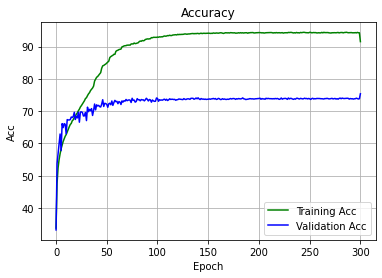

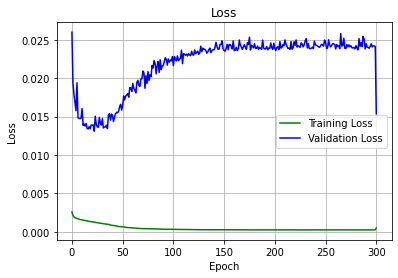

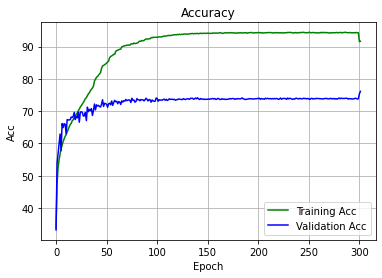

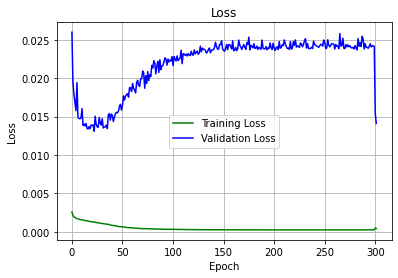

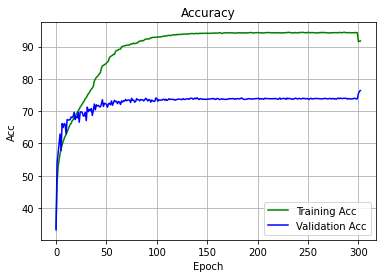

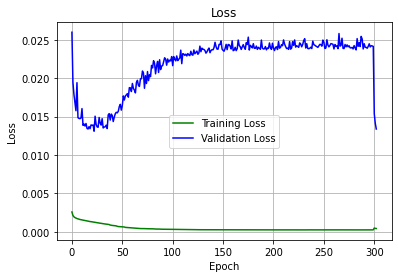

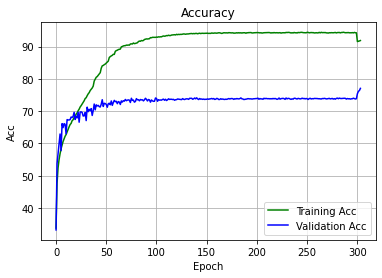

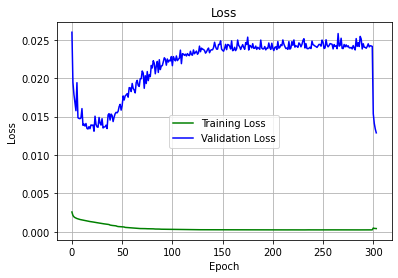

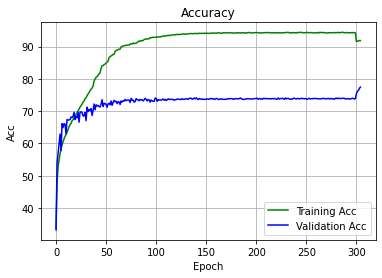

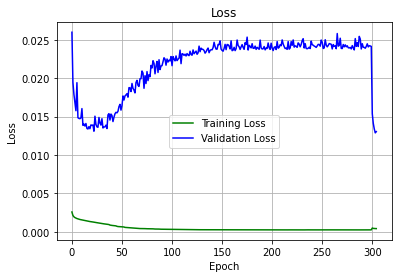

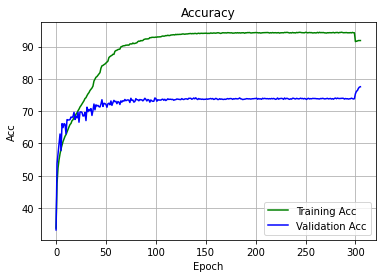

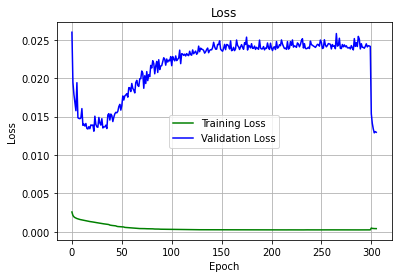

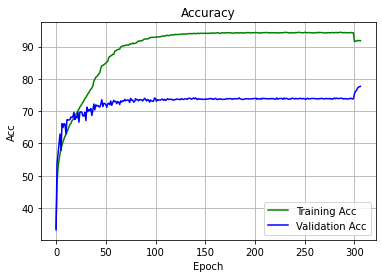

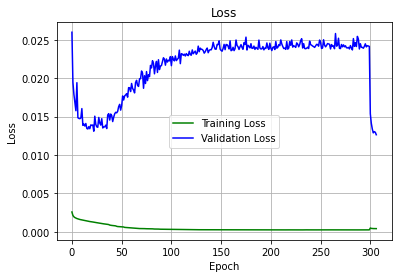

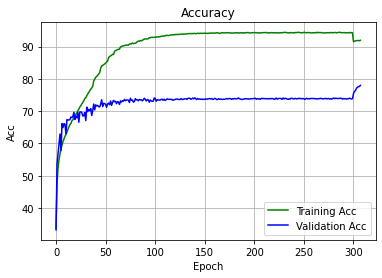

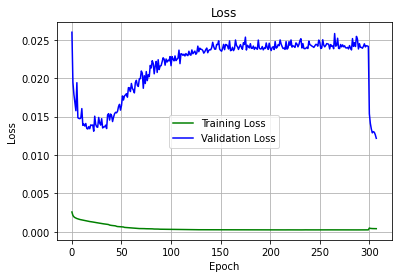

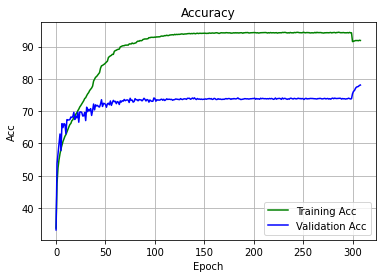

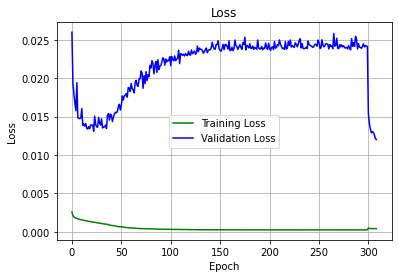

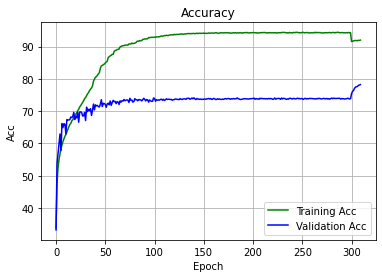

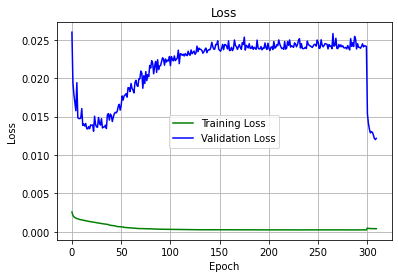

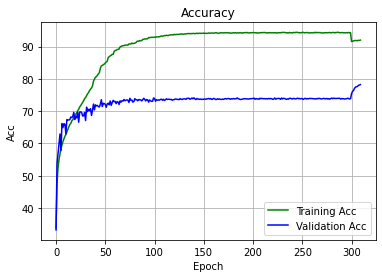

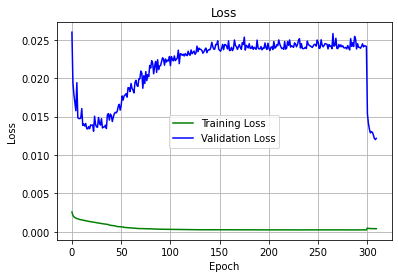

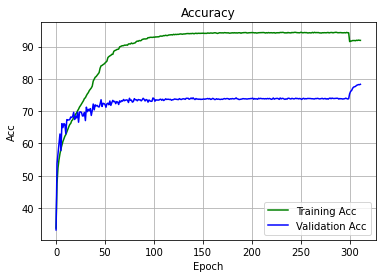

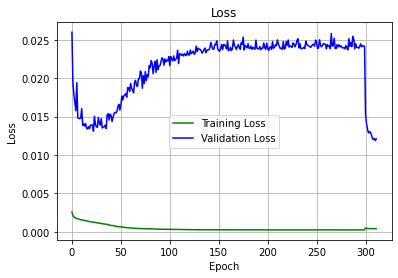

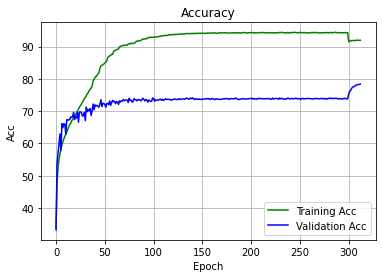

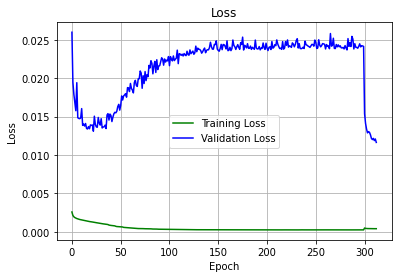

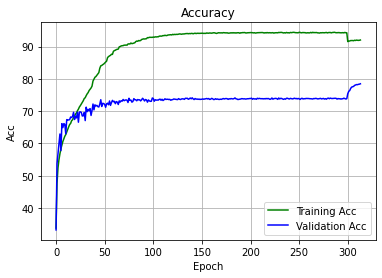

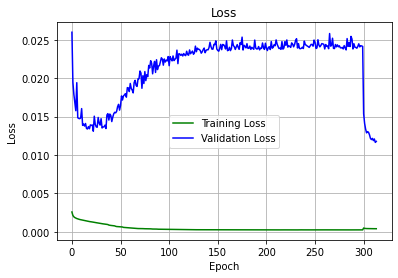

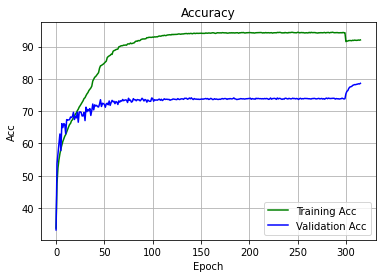

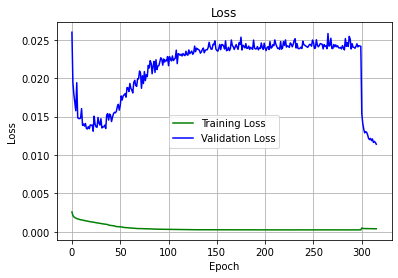

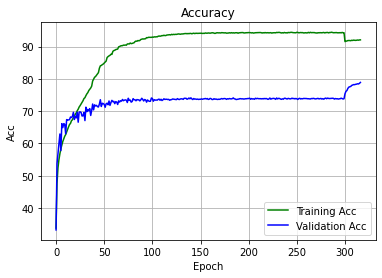

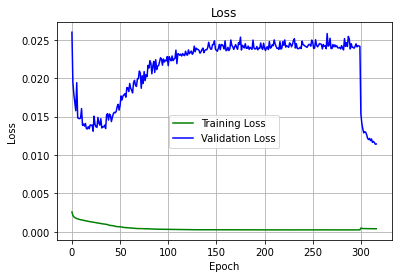

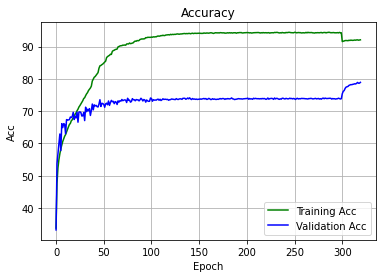

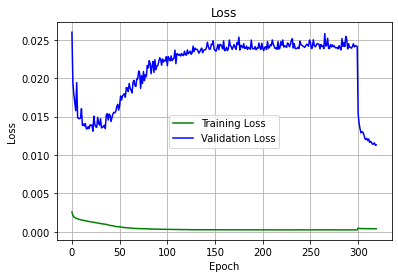

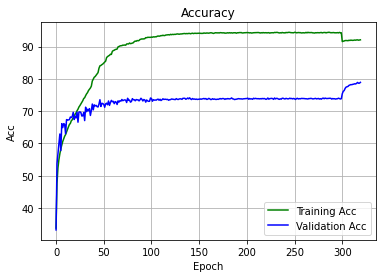

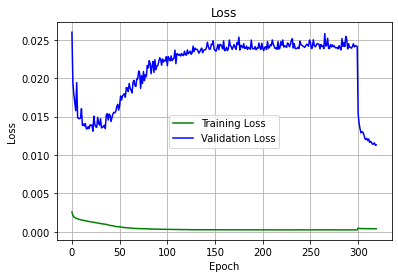

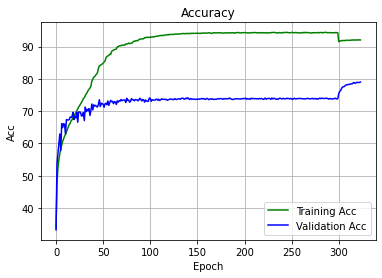

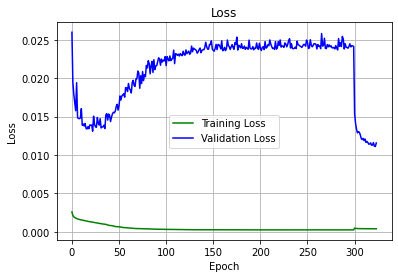

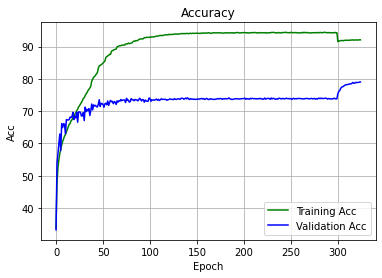

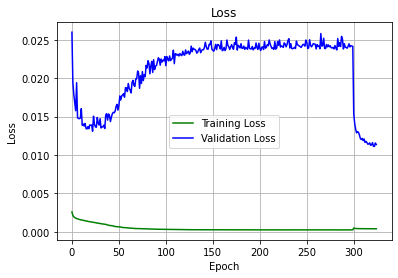

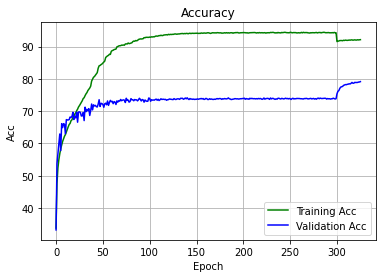

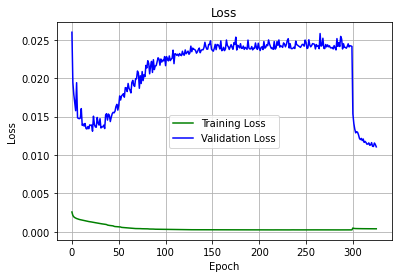

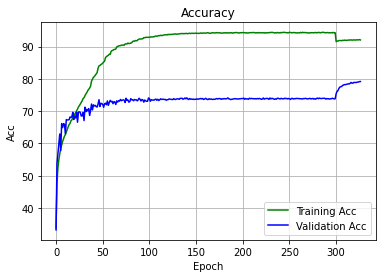

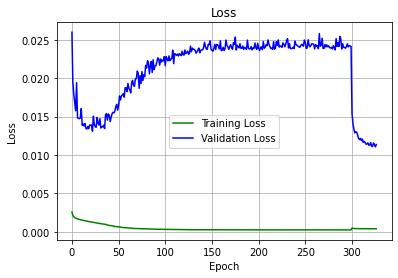

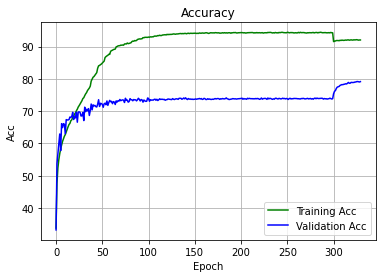

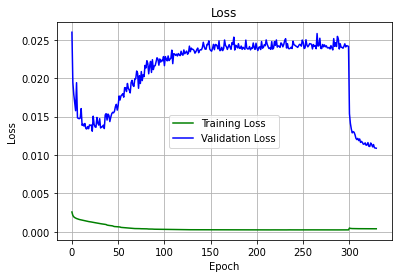

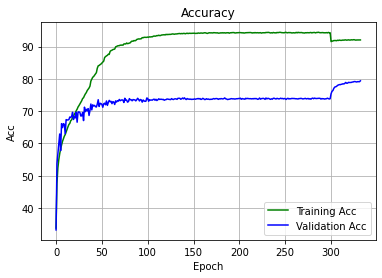

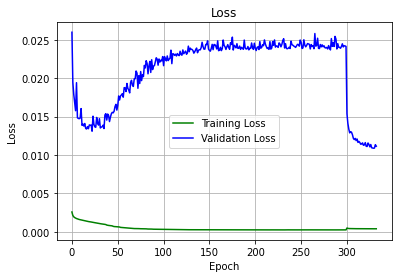

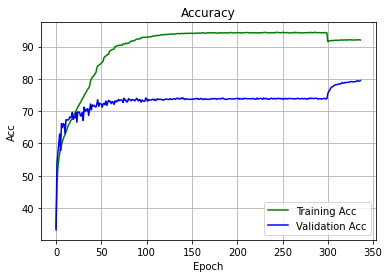

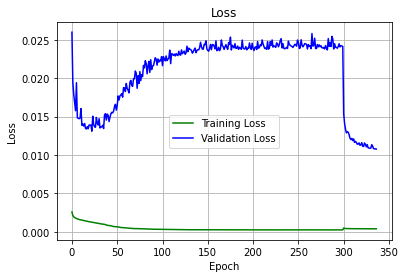

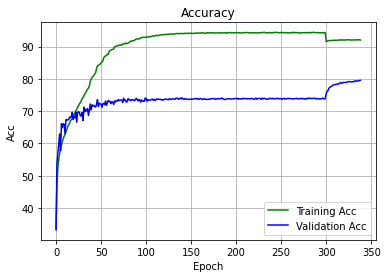

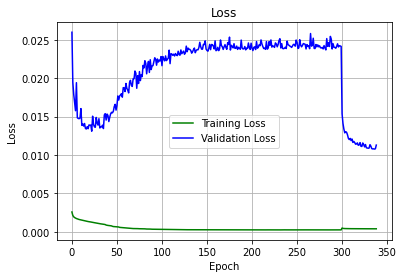

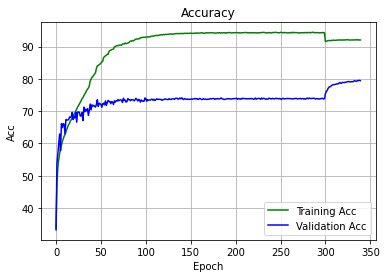

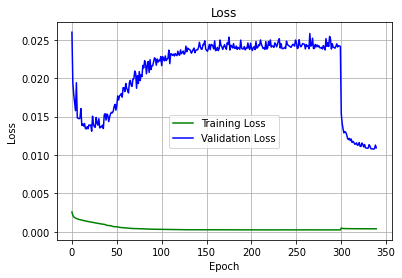

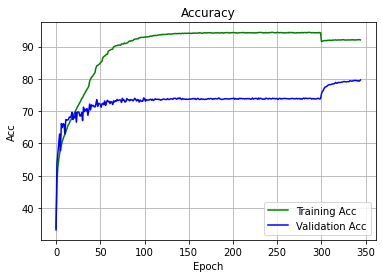

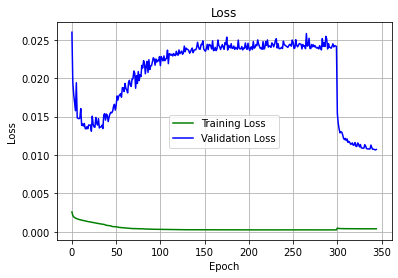

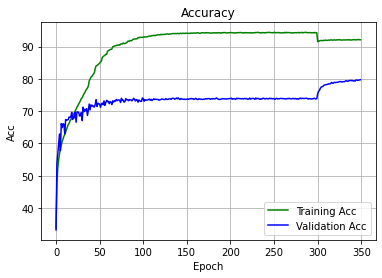

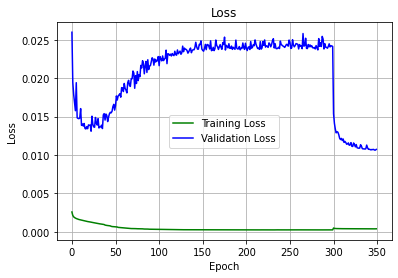

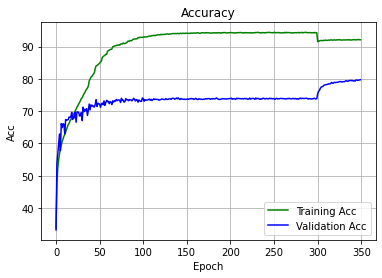

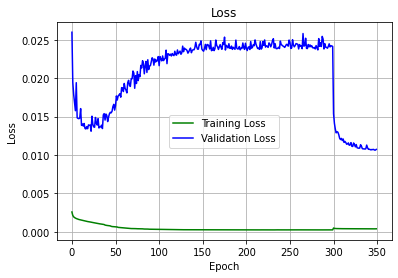

In [20]:
run(net, logger, hps)

# Evaluate

In [21]:
class Logger:
    def __init__(self):
        self.loss_train = []
        self.loss_val = []

        self.acc_train = []
        self.acc_val = []

    def get_logs(self):
        return self.loss_train, self.loss_val, self.acc_train, self.acc_val

    def restore_logs(self, logs):
        self.loss_train, self.loss_val, self.acc_train, self.acc_val = logs

    def show_plt(self):

        plt.figure()
        plt.plot(self.acc_train, 'g', label='Training Acc')
        plt.plot(self.acc_val, 'b', label='Validation Acc')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Acc')
        plt.legend()
        plt.grid()
        plt.show()

        plt.figure()
        plt.plot(self.loss_train, 'g', label='Training Loss')
        plt.plot(self.loss_val, 'b', label='Validation Loss')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()
        plt.show()



In [22]:
from sklearn.metrics import precision_score, f1_score, recall_score, confusion_matrix
def correct_count(output, target, topk=(1,)):
    """Computes the top k corrrect count for the specified values of k"""
    maxk = max(topk)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].contiguous().view(-1).float().sum(0, keepdim=True)
        res.append(correct_k)
    return res

def evaluate(net, dataloader, criterion):
    net = net.eval()
    loss_tr, n_samples = 0.0, 0.0

    y_pred = []
    y_gt = []

    correct_count1 = 0
    correct_count2 = 0

    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # fuse crops and batchsize
        bs, ncrops, c, h, w = inputs.shape
        inputs = inputs.view(-1, c, h, w)

        # forward
        outputs = net(inputs)

        # combine results across the crops
        outputs = outputs.view(bs, ncrops, -1)
        outputs = torch.sum(outputs, dim=1) / ncrops

        loss = criterion(outputs, labels)

        # calculate performance metrics
        loss_tr += loss.item()

        # accuracy
        counts = correct_count(outputs, labels, topk=(1, 2))
        correct_count1 += counts[0].item()
        correct_count2 += counts[1].item()

        _, preds = torch.max(outputs.data, 1)
        preds = preds.to("cpu")
        labels = labels.to("cpu")
        n_samples += labels.size(0)

        y_pred.extend(pred.item() for pred in preds)
        y_gt.extend(y.item() for y in labels)

    acc1 = 100 * correct_count1 / n_samples
    acc2 = 100 * correct_count2 / n_samples
    loss = loss_tr / n_samples
    print("--------------------------------------------------------")
    print("Top 1 Accuracy: %2.6f %%" % acc1)
    print("Top 2 Accuracy: %2.6f %%" % acc2)
    print("Loss: %2.6f" % loss)
    print("Precision: %2.6f" % precision_score(y_gt, y_pred, average='micro'))
    print("Recall: %2.6f" % recall_score(y_gt, y_pred, average='micro'))
    print("F1 Score: %2.6f" % f1_score(y_gt, y_pred, average='micro'))
    print("Confusion Matrix:\n", confusion_matrix(y_gt, y_pred), '\n')


criterion = nn.CrossEntropyLoss()
# Get data with no augmentation
trainloader, valloader, testloader = get_dataloaders(augment=False)

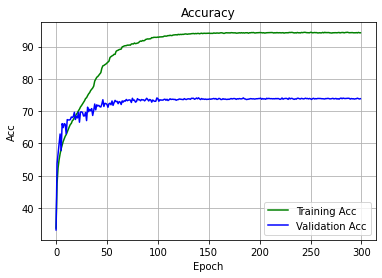

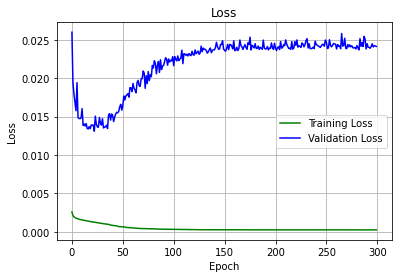

Train
--------------------------------------------------------
Top 1 Accuracy: 96.730448 %
Top 2 Accuracy: 98.643879 %
Loss: 0.002805
Precision: 0.967304
Recall: 0.967304
F1 Score: 0.967304
Confusion Matrix:
 [[4296    2   52   12   80    8   36]
 [   9  474    3    1    1    2    1]
 [  60    1 4360   14   98   43   49]
 [  14    0    7 8013   18   17   25]
 [  50    2   66   18 5183    4  101]
 [  16    0   42   19    4 3499    7]
 [  22    0   36   21   89    6 5417]] 

Val
--------------------------------------------------------
Top 1 Accuracy: 73.836723 %
Top 2 Accuracy: 88.018947 %
Loss: 0.024699
Precision: 0.738367
Recall: 0.738367
F1 Score: 0.738367
Confusion Matrix:
 [[322   2  42  12  72   7  34]
 [  9  39   3   1   1   1   1]
 [ 53   0 299  14  84  30  48]
 [ 13   0   7 802  18  14  25]
 [ 42   2  54  18 375   4  99]
 [ 13   0  30  18   4 344   7]
 [ 19   0  29  21  82   6 469]] 

Test
--------------------------------------------------------
Top 1 Accuracy: 71.886319 %
Top 2

In [23]:
# Load Trained Model
checkpoint = torch.load('result/best/second/myvgg/epoch_300',map_location=torch.device('cpu'))
net = Vgg().to(device)
net.load_state_dict(checkpoint["params"])
net.eval()
logger = Logger()
logger.restore_logs(checkpoint['logs'])
logger.show_plt()
print("Train")
evaluate(net, trainloader, criterion)

print("Val")
evaluate(net, valloader, criterion)

print("Test")
evaluate(net, testloader, criterion)

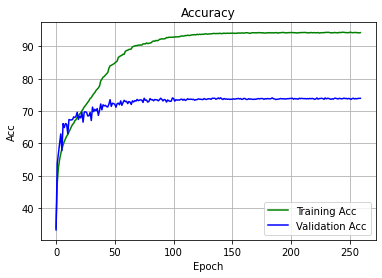

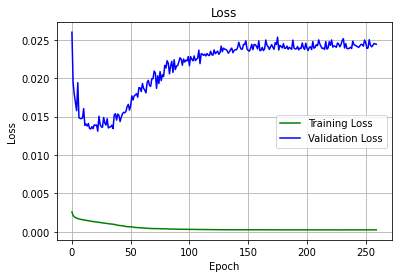

Train
--------------------------------------------------------
Top 1 Accuracy: 96.730448 %
Top 2 Accuracy: 98.634590 %
Loss: 0.002818
Precision: 0.967304
Recall: 0.967304
F1 Score: 0.967304
Confusion Matrix:
 [[4299    2   51   12   78    8   36]
 [   9  474    3    1    1    2    1]
 [  64    1 4352   14   97   48   49]
 [  14    0    7 8015   16   16   26]
 [  47    2   69   22 5180    4  100]
 [  15    0   37   21    4 3502    8]
 [  20    0   35   22   87    7 5420]] 

Val
--------------------------------------------------------
Top 1 Accuracy: 73.948175 %
Top 2 Accuracy: 87.935358 %
Loss: 0.023965
Precision: 0.739482
Recall: 0.739482
F1 Score: 0.739482
Confusion Matrix:
 [[325   2  41  12  70   7  34]
 [  9  39   3   1   1   1   1]
 [ 54   0 296  14  83  33  48]
 [ 13   0   7 804  16  13  26]
 [ 39   2  57  22 372   4  98]
 [ 12   0  27  19   4 346   8]
 [ 17   0  28  22  80   7 472]] 

Test
--------------------------------------------------------
Top 1 Accuracy: 72.053497 %
Top 2

In [29]:
checkpoint = torch.load('result/best/second/myvgg/epoch_260',map_location=torch.device('cpu'))
net = Vgg().to(device)
net.load_state_dict(checkpoint["params"])
net.eval()
logger = Logger()
logger.restore_logs(checkpoint['logs'])
logger.show_plt()
print("Train")
evaluate(net, trainloader, criterion)

print("Val")
evaluate(net, valloader, criterion)

print("Test")
evaluate(net, testloader, criterion)